In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import re


from sklearn.model_selection import train_test_split

# K Means Clustering
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# DT 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV 

# Boosted DT 
from sklearn.ensemble import AdaBoostRegressor

# Scaler for ANN
from sklearn.preprocessing import StandardScaler

# Random Forest
from sklearn.ensemble import RandomForestRegressor 


# ANN
from sklearn.neural_network import MLPRegressor

# KMeans 
from sklearn.cluster import KMeans

# SVM
from sklearn.svm import SVR 

# KNN
from sklearn.neighbors import KNeighborsRegressor 

import scipy
from scipy import stats


import xgboost

In [284]:
os.listdir()


['imdb_updated',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Params.xlsx',
 '~$Movies_2020.xlsx',
 'IMDB',
 '.ipynb_checkpoints']

In [285]:
data = pd.read_excel('Movies_2020.xlsx', 
                    dtype = {'ReleaseYear': int}
                    )

In [286]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama


In [287]:
print("There are ",data.shape[0], " movies in this dataset")

There are  166  movies in this dataset


In [288]:
data.dtypes

Name                   object
Rating                float64
WatchDate      datetime64[ns]
ReleaseYear             int64
Director               object
Genre                  object
dtype: object

In [289]:
data.isna().sum()

Name           0
Rating         0
WatchDate      0
ReleaseYear    0
Director       0
Genre          0
dtype: int64

#### The movie watchings are skewed heavily toward recent movies, with some noticable peaks in 1950s (due to Hitchcock & Audrey Hepburn films)

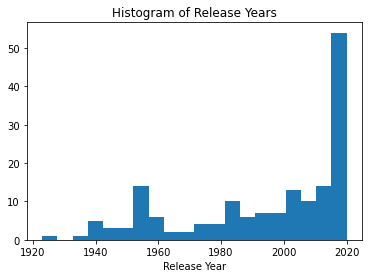

In [290]:
plt.hist(data['ReleaseYear'], bins = 20)
plt.xlabel('Release Year')
plt.title("Histogram of Release Years")
plt.show()

#### The Ratings also show that I generally rate movies highly, this distribution is right-skewed as well

In [291]:
data['Rating'].describe()

count    166.000000
mean       0.790663
std        0.140282
min        0.250000
25%        0.700000
50%        0.845000
75%        0.900000
max        0.990000
Name: Rating, dtype: float64

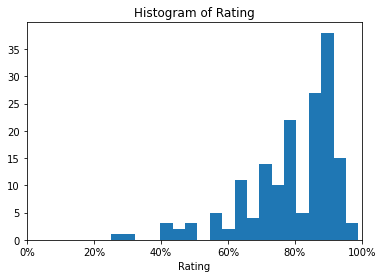

In [292]:
plt.hist(data['Rating'], bins = 20)
plt.xlabel('Rating')
plt.xlim(0, 1)
plt.title("Histogram of Rating")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

#### My movie intake is quite high during the 2020 Global Covid-19 Pandemic. It also was pretty high in early 2016, as I was in my senior spring of college. This charts the quarterly sum of movies. 

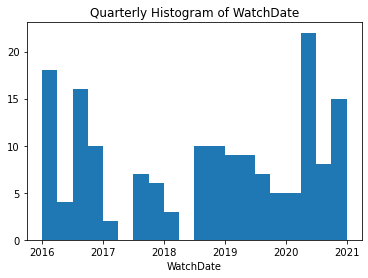

In [293]:
plt.hist(data['WatchDate'], bins = 20)
plt.xlabel('WatchDate')
plt.title("Quarterly Histogram of WatchDate")
plt.show()

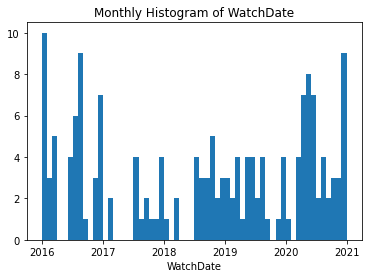

In [294]:
plt.hist(data['WatchDate'], bins = 60)
plt.xlabel('WatchDate')
plt.title("Monthly Histogram of WatchDate")
plt.show()

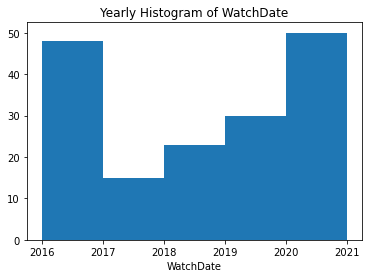

In [295]:
plt.hist(data['WatchDate'], bins = 5)
plt.xlabel('WatchDate')
plt.title("Yearly Histogram of WatchDate")
plt.show()

#### What is my average rating over time?

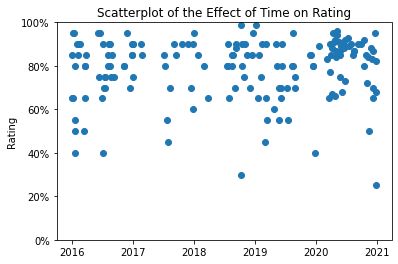

In [296]:
plt.scatter(data['WatchDate'], data['Rating'])
plt.title("Scatterplot of the Effect of Time on Rating")
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### Am I watching newer movies over time?

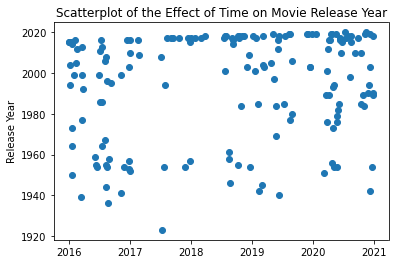

In [297]:
plt.scatter(data['WatchDate'], data['ReleaseYear'])
plt.title("Scatterplot of the Effect of Time on Movie Release Year")
plt.ylabel('Release Year')
plt.show()

#### Create a Monthly Aggregation to Summarize Trends

In [298]:

data['WatchMonth'] = data['WatchDate'].values.astype('datetime64[M]')

data_month = data.groupby(['WatchMonth']).agg(
                    count = pd.NamedAgg( column = 'Name', aggfunc = 'count'),
                    rating = pd.NamedAgg( column = 'Rating', aggfunc = 'mean'),
                    movieyear = pd.NamedAgg( column = 'ReleaseYear', aggfunc = 'mean')
                )
data_month = data_month.reset_index()
#data_month.rename(columns = {'Name':'Count'}, inplace = True)
data_month.head()


,WatchMonth,count,rating,movieyear
0,2016-01-01,10,0.720000,1994.30
1,2016-02-01,3,0.883333,2011.00
2,2016-03-01,5,0.720000,1984.00
3,2016-06-01,4,0.825000,1966.75
4,2016-07-01,6,0.700000,1996.00


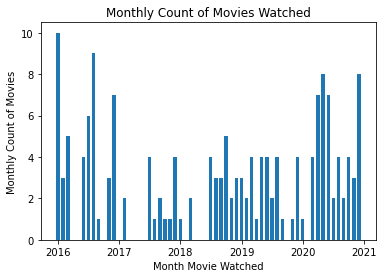

In [299]:
plt.bar(data_month['WatchMonth'], data_month['count'], width = 20)
plt.xlabel('Month Movie Watched')
plt.ylabel('Monthly Count of Movies')
plt.title('Monthly Count of Movies Watched')
plt.show()

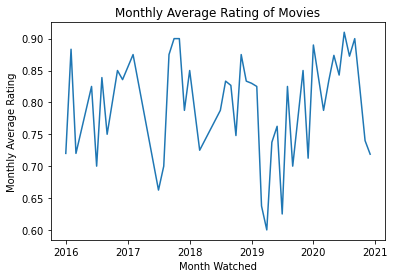

In [300]:
plt.plot(data_month['WatchMonth'], data_month['rating'])
plt.title('Monthly Average Rating of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Rating')
plt.show()

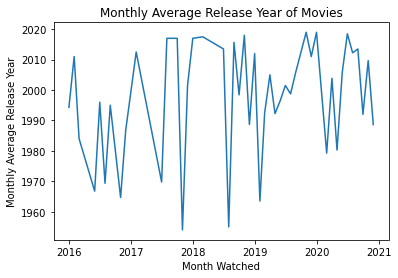

In [301]:
plt.plot(data_month['WatchMonth'], data_month['movieyear'])
plt.title('Monthly Average Release Year of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Release Year')
plt.show()

#### Is there a relationship between Year of the Movie Release and my Rating?

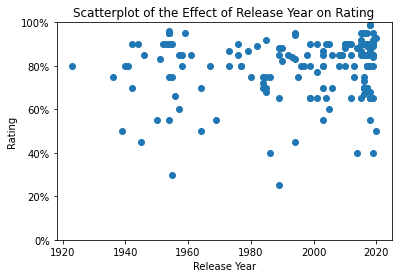

In [302]:
plt.scatter(data['ReleaseYear'], data['Rating'])
plt.title('Scatterplot of the Effect of Release Year on Rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### What are my highest rated movies?

In [303]:
data.sort_values(by=['Rating'], ascending = False).head(10)

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth
86,On the Basis of Sex,0.99,2019-01-06,2018,Mimi Leder,Historical/Drama,2019-01-01
77,Colette,0.99,2018-10-12,2018,Wash Westmoreland,Historical/Drama,2018-10-01
130,Rear Window,0.96,2020-05-05,1954,Alfred Hitchcock,Noir/Mystery,2020-05-01
18,North by Northwest,0.95,2016-06-08,1959,Alfred Hitchcock,Mystery/Drama,2016-06-01
62,The Big Sick,0.95,2017-12-30,2017,Michael Showalter,Romance/Drama,2017-12-01
40,White Christmas,0.95,2016-11-26,1954,Michael Curtiz,Romance/Musical,2016-11-01
124,Hidden Figures,0.95,2020-04-10,2016,Theodore Melfi,Drama/History,2020-04-01
108,The Farewell,0.95,2019-08-17,2019,Lulu Wang,Drama/Comedy,2019-08-01
20,Rear Window,0.95,2016-06-19,1954,Alfred Hitchcock,Thriller/Mystery,2016-06-01
85,White Christmas,0.95,2018-12-23,1954,Michael Curtiz,Romance/Comedy,2018-12-01


#### Which Director have I seen the most movies from?

In [304]:
data['Director'].value_counts().head()

Alfred Hitchcock     8
Michael Curtiz       5
Robert Zemeckis      4
Damien Chazelle      4
Sylvester Stalone    3
Name: Director, dtype: int64

#### Which movies have I rewatched the most? 

In [305]:
data['Name'].value_counts().head(11)

White Christmas                                                         4
The Big Short                                                           3
Love Actually                                                           3
Rear Window                                                             2
Forrest Gump                                                            2
Ghostbusters                                                            2
Elf                                                                     2
The Breakfast Club                                                      2
Vertigo                                                                 2
La La Land                                                              2
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb    2
Name: Name, dtype: int64

#### Does my Rating usually increase or decrease upon rewatching? 

In [306]:
#data.groupby('Name').filter(lambda x: len(x) >= 2)

In [307]:
repeat_list =  data.groupby('Name').filter(lambda x: len(x) >= 2)['Name'].unique()
repeat_list

array(['Forrest Gump', 'The Big Short',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
       'Rear Window', 'Vertigo', 'White Christmas', 'Love Actually',
       'La La Land', 'Ghostbusters', 'The Breakfast Club', 'Elf'],
      dtype=object)

In [308]:
for i in range(0, len(repeat_list)):
    print(repeat_list[i])
    print(data[data['Name'] == repeat_list[i]][['Name','Rating']])

Forrest Gump
             Name  Rating
3    Forrest Gump    0.95
131  Forrest Gump    0.94
The Big Short
              Name  Rating
4    The Big Short    0.95
61   The Big Short    0.90
142  The Big Short    0.92
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
                                                 Name  Rating
7   Dr. Strangelove or: How I Learned to Stop Worr...     0.5
25  Dr. Strangelove or: How I Learned to Stop Worr...     0.7
Rear Window
            Name  Rating
20   Rear Window    0.95
130  Rear Window    0.96
Vertigo
       Name  Rating
36  Vertigo    0.85
70  Vertigo    0.80
White Christmas
                Name  Rating
40   White Christmas    0.95
58   White Christmas    0.90
85   White Christmas    0.95
162  White Christmas    0.95
Love Actually
              Name  Rating
42   Love Actually    0.85
83   Love Actually    0.70
114  Love Actually    0.80
La La Land
          Name  Rating
48  La La Land     0.9
74  La La Land     0.9
Ghostbusters
 

#### Drop the Date Watching, Take the Average Rating per Each Movie

In [309]:
data = data.groupby(['Name']).agg(
                Rating = pd.NamedAgg(column = 'Rating', aggfunc = 'mean'),
                Genre = pd.NamedAgg(column = 'Genre', aggfunc = lambda x: x.value_counts().index[0]),
                ReleaseYear = pd.NamedAgg(column = 'ReleaseYear', aggfunc = lambda x: x.value_counts().index[0]),
                Director = pd.NamedAgg(column = 'Director', aggfunc = lambda x: x.value_counts().index[0])
                )

data = data.reset_index()

In [310]:
data.shape

(151, 5)

In [311]:
#data.groupby(['Name'], as_index=False)['Rating'].mean()

### Label Encoding the Genre Column 

In [312]:
data[['Genre1','Genre2']] = data['Genre'].str.split('/',expand=True)
data['Genre2'] = data['Genre2'].fillna(data['Genre1'])

In [313]:
data.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2
0,13th,0.90,Documentary/History,2016,Ava DuVernay,Documentary,History
1,500 Days of Summer,0.85,Romance/Drama,2009,Marc Webb,Romance,Drama
2,A Beautiful Day in the Neighborhood,0.85,Drama,2019,Marielle Heller,Drama,Drama
3,All the President's Men,0.90,Drama/Thriller,1976,Alan J. Pakula,Drama,Thriller
4,Along Came Polly,0.65,Romance/Comedy,2004,Hamburg,Romance,Comedy


### Manually Label Encode Genre

Due to the mispellings in the underlying dataset, do manual combinations to reduce the dimensionality of the dataset

In [314]:

data['Romance_Ind'] = 0 
r = re.compile(r'.*(Romance).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Romance_Ind'] = 1
  
data['Comedy_Ind'] = 0 
r = re.compile(r'.*(Comedy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Comedy_Ind'] = 1
 
data['Drama_Ind'] = 0 
r = re.compile(r'.*(Drama).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Drama_Ind'] = 1

data['Thriller_Ind'] = 0 
r = re.compile(r'.*(Thriller).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Thriller_Ind'] = 1
 
data['Fantasy_Ind'] = 0 
r = re.compile(r'.*(Fantasy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Fantasy_Ind'] = 1

data['Crime_Ind'] = 0 
r = re.compile(r'.*(Crime).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Crime_Ind'] = 1

data['Sport_Ind'] = 0 
r = re.compile(r'.*(Sport).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Sport_Ind'] = 1

data['Historical_Ind'] = 0 
r = re.compile(r'.*(Historical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Historical_Ind'] = 1


data['Mystery_Ind'] = 0 
r = re.compile(r'.*(Mystery).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Mystery_Ind'] = 1


data['Action_Ind'] = 0 
r = re.compile(r'.*(Action).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Action_Ind'] = 1


data['Musical_Ind'] = 0 
r = re.compile(r'.*(Musical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Musical_Ind'] = 1


data['SciFi_Ind'] = 0 
r = re.compile(r'.*(Sci).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'SciFi_Ind'] = 1

data['Other_Ind'] = 0
data.loc[ (data['Romance_Ind'] == 0) & (data['Comedy_Ind'] == 0) & (data['Drama_Ind'] == 0) & \
          (data['Thriller_Ind'] == 0) & (data['Fantasy_Ind'] == 0) & (data['Crime_Ind'] == 0) & \
         (data['Sport_Ind'] == 0) & (data['Historical_Ind'] == 0) & (data['Mystery_Ind'] == 0) & \
         (data['Action_Ind'] == 0) & (data['Musical_Ind'] == 0 ) & (data['SciFi_Ind'] == 0)
         , 'Other_Ind'] = 1



In [315]:
data.describe()

,Rating,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.784796,1995.178808,0.225166,0.304636,0.556291,0.072848,0.066225,0.059603,0.052980,0.046358,0.099338,0.052980,0.072848,0.072848,0.026490
std,0.141229,25.836947,0.419081,0.461785,0.498474,0.260751,0.249503,0.237537,0.224739,0.210958,0.300110,0.224739,0.260751,0.260751,0.161122
min,0.250000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,1979.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.830000,2005.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,2017.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [316]:
data.iloc[:, 9:].sum()

Drama_Ind         84
Thriller_Ind      11
Fantasy_Ind       10
Crime_Ind          9
Sport_Ind          8
Historical_Ind     7
Mystery_Ind       15
Action_Ind         8
Musical_Ind       11
SciFi_Ind         11
Other_Ind          4
dtype: int64

In [317]:
data.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,13th,0.90,Documentary/History,2016,Ava DuVernay,Documentary,History,0,0,0,0,0,0,0,0,0,0,0,0,1
1,500 Days of Summer,0.85,Romance/Drama,2009,Marc Webb,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0
2,A Beautiful Day in the Neighborhood,0.85,Drama,2019,Marielle Heller,Drama,Drama,0,0,1,0,0,0,0,0,0,0,0,0,0
3,All the President's Men,0.90,Drama/Thriller,1976,Alan J. Pakula,Drama,Thriller,0,0,1,1,0,0,0,0,0,0,0,0,0
4,Along Came Polly,0.65,Romance/Comedy,2004,Hamburg,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0


#### Split the Data

In [318]:
X = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind']]
y = data.loc[:, 'Rating']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = .20, train_size = .80, random_state = 42)
    

In [319]:
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(120, 14)
(120,)
(31, 14)
(31,)


In [320]:
X_Train.head()

,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
15,2017,0,0,0,0,0,0,0,0,0,0,1,0,0
125,1941,0,0,0,0,0,1,0,0,1,0,0,0,0
11,1989,0,0,0,0,0,0,0,0,0,0,0,1,0
127,2017,0,0,1,0,0,0,0,1,0,0,0,0,0
51,2016,0,0,1,0,0,0,0,0,0,0,0,0,0


#### We can't do Clustering on a Binary Dataset. We will have to get something else - such as 'Sentiment Score' using NLP Methods. 
#### Get Sentiment using NLTK, then use that as an input to Clustering 

### Decision Tree on Binary Genre + Release Year Data 

#### 1) Decision Tree

In [321]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.6062967613267602
Mean Squared Error: 0.03413897849462364


Grid Search for Best Parameters

In [322]:
def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['mse', 'mae','friedman_mse']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(3, 13, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeRegressor(random_state=42),
                       param_grid=param_grid, 
                       #scoring='neg_mean_squared_error',
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [323]:
make_GridSearchCV_DT(X_Train, Y_Train)

0.008924314336674132
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 8, 'splitter': 'best'}


R2 Score: 0.03963601637500613
Mean Squared Error: 0.02041082704848666


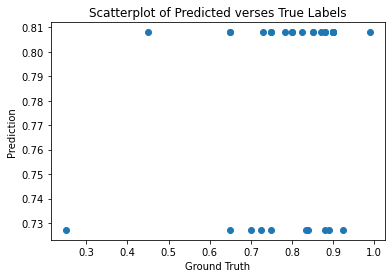

In [324]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = 1, min_samples_leaf = 8,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

In [325]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: 0.05661597279710828
Mean Squared Error: 0.0200499482986254


In [326]:
def make_GridSearchCV_Boosted_DT(X_Train, Y_Train):

    losses = ['linear', 'square', 'exponential']
    learning_rates = np.arange(0.5,1,step=0.10)
    num_est = np.arange(10,100,step=5)

    param_grid = {'loss': losses, 'learning_rate': learning_rates, 'n_estimators': num_est}

    classifier = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [327]:
make_GridSearchCV_Boosted_DT(X_Train, Y_Train)

-0.1255987786595193
{'learning_rate': 0.7999999999999999, 'loss': 'linear', 'n_estimators': 10}


R2 Score: 0.18140964373675805
Mean Squared Error: 0.017397680952363107


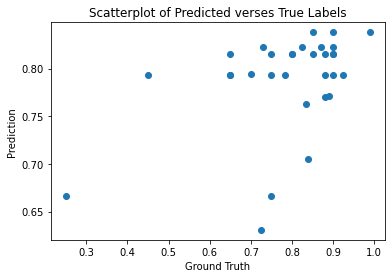

In [328]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'linear', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [329]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -1.100460503817807
Mean Squared Error: 0.044641549242378994


In [330]:
# This one is only for the Polling Data 
def make_GridSearchCV_ANN(X_Train, Y_Train):
    
    activations = ['identity', 'relu', 'tanh', 'logistic']
    solvers = ['adam']
    hidden_layers = list(np.arange(5, 100, 5))
    
    init_learning_rates = [0.01, 0.05]
    
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPRegressor(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [331]:
make_GridSearchCV_ANN(X_Train, Y_Train)

0.007441865519481139
{'activation': 'identity', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.05, 'solver': 'adam'}


R2 Score: 0.041531328401631984
Mean Squared Error: 0.020370545564967927


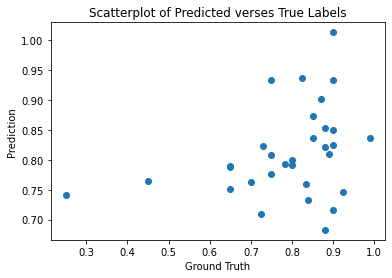

In [332]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'identity', solver = 'adam', random_state = 42,
                          hidden_layer_sizes = 20, learning_rate_init = 0.05)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) KNN

In [333]:
sc = StandardScaler()
X_Train_sc = sc.fit_transform(X_Train)
X_Test_sc = sc.transform(X_Test)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_sc, Y_Train)
Y_Test_Pred = knn_model.predict(X_Test_sc)
            
print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: 0.09297657316350671
Mean Squared Error: 0.019277168458781368


In [334]:
def make_GridSearchCV_KNN(X_Train, Y_Train):
    
    ks = np.arange(1, 90, step = 2)
    ps = np.arange(1, 3, step = 1)

    weights = ['uniform', 'distance'] 
    param_grid = { 'n_neighbors': ks, 'weights': weights, 'p': ps}

    classifier = GridSearchCV(KNeighborsRegressor(),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [335]:
make_GridSearchCV_KNN(X_Train_sc, Y_Train)

0.01282135375643174
{'n_neighbors': 27, 'p': 1, 'weights': 'uniform'}


R2 Score: 0.12058955056531628
Mean Squared Error: 0.018690303774503304


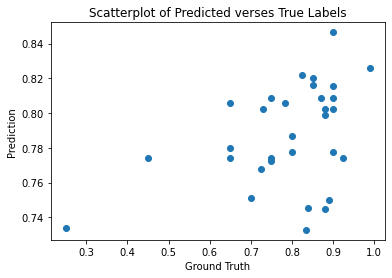

In [336]:
sc = StandardScaler()
X_Train_sc = sc.fit_transform(X_Train)
X_Test_sc = sc.transform(X_Test)

knn_model = KNeighborsRegressor(n_neighbors = 27, weights = 'uniform', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_sc, Y_Train)
Y_Test_Pred = knn_model.predict(X_Test_sc)
            
print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 5) Random Forest 

In [337]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train, Y_Train)
Y_Test_Pred = rf_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: 0.026522924135346515
Mean Squared Error: 0.02068952248306999


In [338]:
def make_GridSearchCV_RF(X_Train, Y_Train):

    #num_est = np.arange(10,100,step=5)
    num_est = [50, 100]
    criterions = ['mse']
    #max_depths = list(np.arange(1, 20, 2))
    max_depths = list(np.arange(3, 20, 2))
    #min_samples_leaf = list(np.arange(10, 20, 1))
    min_samples_leaf = list(np.arange(10, 20, 1))
    
    param_grid = {'n_estimators': num_est, 'criterion': criterions,
                 'max_depth': max_depths, 'min_samples_leaf': min_samples_leaf}

    classifier = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [339]:
make_GridSearchCV_RF(X_Train, Y_Train)

-0.016326350126390367
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 14, 'n_estimators': 100}


R2 Score: 0.026522924135346515
Mean Squared Error: 0.02068952248306999


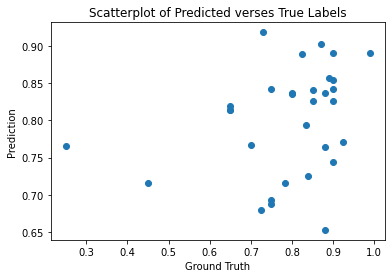

In [340]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train, Y_Train)
Y_Test_Pred = rf_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 6) SVM

In [566]:
sc = StandardScaler()
X_Train_sc = sc.fit_transform(X_Train)
X_Test_sc = sc.transform(X_Test)

svm_model = SVR(C = 1.0, kernel = 'rbf', degree = 3)
svm_model.fit(X_Train_sc, Y_Train)
Y_Test_Pred = svm_model.predict(X_Test_sc)
            
print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: 0.15768342524182666
Mean Squared Error: 0.01790193949440746


In [563]:
def make_GridSearchCV_SVM(X_Train, Y_Train):
    
    cs = [1,10]
    #cs = [1]
    kernels = ['linear','rbf', 'poly']
    degrees = [2, 3, 4]
    #degrees = [ 3]
    
    param_grid = {'C': cs, 'kernel': kernels, 'degree': degrees}

    classifier = GridSearchCV(SVR(),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    

In [567]:
make_GridSearchCV_SVM(X_Train_sc, Y_Train)

-0.04663765923071321
{'C': 10, 'degree': 2, 'kernel': 'linear'}


R2 Score: 0.1463281981614034
Mean Squared Error: 0.018143274633986493


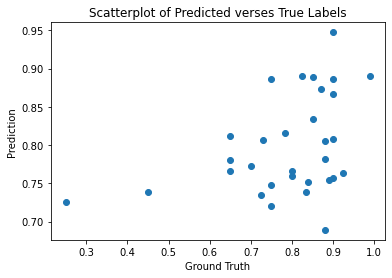

In [572]:
sc = StandardScaler()
X_Train_sc = sc.fit_transform(X_Train)
X_Test_sc = sc.transform(X_Test)

svm_model = SVR(C = 10, kernel = 'linear', degree = 2)
svm_model.fit(X_Train_sc, Y_Train)
Y_Test_Pred = svm_model.predict(X_Test_sc)
            
print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### We need to find some better features. Let's explore NLP Sentiment of the Movie Genre

### 1) NLTK Vader Compound Score

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [341]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def show_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [342]:
print(data.loc[0,['Genre1']])

word = str(data.loc[0,['Genre1']])
show_vader_score(word)

Genre1    Documentary
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 


In [343]:
for i in range(0, 5):
    print(data.loc[i,['Genre1']])

    word = str(data.loc[i,['Genre1']])
    show_vader_score(word)

Genre1    Documentary
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Romance
Name: 1, dtype: object
compound: 0.5574, 
neg: 0.0, 
neu: 0.581, 
pos: 0.419, 
Genre1    Drama
Name: 2, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Drama
Name: 3, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Romance
Name: 4, dtype: object
compound: 0.5574, 
neg: 0.0, 
neu: 0.581, 
pos: 0.419, 


In [344]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    return (ss['compound'])


In [345]:
# Apply this function to my Genre Columns
data['Genre1_NLTK'] = data['Genre1'].apply(get_vader_score)
data['Genre2_NLTK'] = data['Genre2'].apply(get_vader_score)
data['Genre_NLTK'] = (data['Genre1_NLTK'] + data['Genre2_NLTK']) / 2

#### Much of the NLTK Vader Compound Scores are Zero - let us look for a wider range of scores with other Libraries

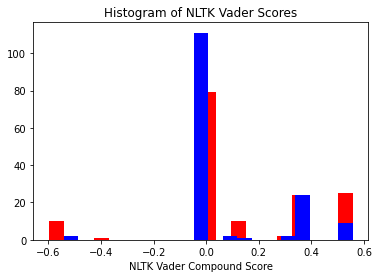

In [346]:
plt.hist(data['Genre1_NLTK'], bins = 20, color = 'red')
plt.hist(data['Genre2_NLTK'], bins = 20, color = 'blue')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

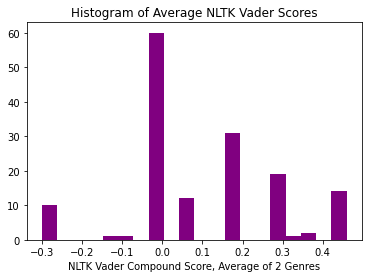

In [347]:
plt.hist(data['Genre_NLTK'], bins = 20, color = 'purple')
plt.xlabel('NLTK Vader Compound Score, Average of 2 Genres')
plt.title('Histogram of Average NLTK Vader Scores')
plt.show()

### 2) Textblob Polarity Score

In [348]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [349]:
data['Genre1_TB'] = data['Genre1'].apply(get_textBlob_score)
data['Genre2_TB'] = data['Genre2'].apply(get_textBlob_score)
data['Genre_TB'] = (data['Genre1_TB'] + data['Genre2_TB']) / 2

#### Textblob Scores are even less spread out than NLTK Vader Scores

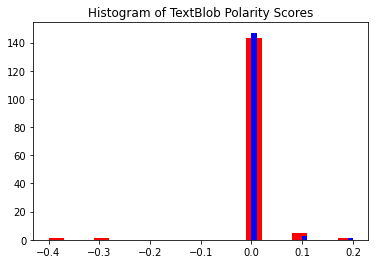

In [350]:
plt.hist(data['Genre1_TB'], bins = 20, color = 'red')
plt.hist(data['Genre2_TB'], bins = 20, color = 'blue')

plt.title('Histogram of TextBlob Polarity Scores')
plt.show()

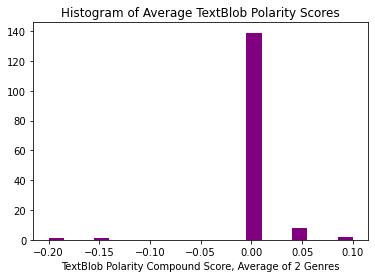

In [351]:
plt.hist(data['Genre_TB'], bins = 20, color = 'purple')
plt.xlabel('TextBlob Polarity Compound Score, Average of 2 Genres')
plt.title('Histogram of Average TextBlob Polarity Scores')
plt.show()

### 3) SpaCy Sentiment 

In [352]:
import spacy



In [353]:
#!python -m spacy download en

#spacy.load('en_core_web_sm')
nlp_spacy = spacy.load('en')

docs = nlp_spacy('romance comedy action crime drama horror musical')

for word in docs:
    print(word.text,word.pos_, word.sentiment)

romance NOUN 0.0
comedy PROPN 0.0
action NOUN 0.0
crime NOUN 0.0
drama NOUN 0.0
horror NOUN 0.0
musical ADJ 0.0


#### Examine NLTK vs Rating

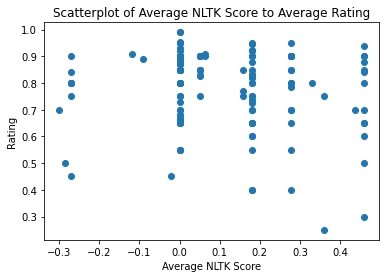

In [354]:
plt.scatter(data['Genre_NLTK'], data['Rating'])
plt.xlabel('Average NLTK Score')
plt.ylabel('Rating')
plt.title('Scatterplot of Average NLTK Score to Average Rating')
plt.show()

#### Examine NLTK vs Release Year

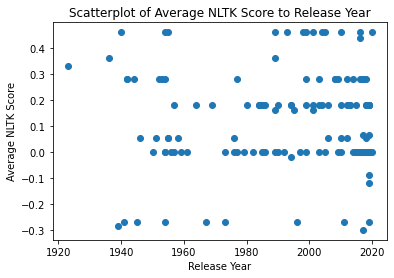

In [355]:
plt.scatter(data['ReleaseYear'], data['Genre_NLTK'])
plt.ylabel('Average NLTK Score')
plt.xlabel('Release Year')
plt.title('Scatterplot of Average NLTK Score to Release Year')
plt.show()

### Revisit Clustering Algorithms, Using NLTK Vader Compound Genre Score + Movie Release Year to Determine the Clusters 

### Cluster Using These Methods:
- K Means
- Expectation Maximization
- Heirarchical

### 1) K-Means

#### How many clusters should we pick? Use Elbow Method 

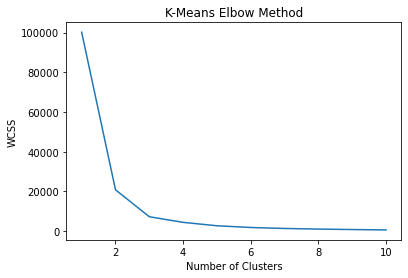

In [356]:
X = data.loc[:, ['ReleaseYear','Genre_NLTK']].values

# Use elbow method to find optimal number of Clusters 

wcss = [] 

# fit KMeans to our data X 
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 43)
    kmeans.fit(X)
    # compute WCSS and append to our list, also called 'Inertia' in KMeans class 
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [357]:
#import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

We want to Maximize Silhouette Score and Minimize Inertia - find place where Inertia is no longer decreasing as fast. 

<Figure size 432x288 with 0 Axes>

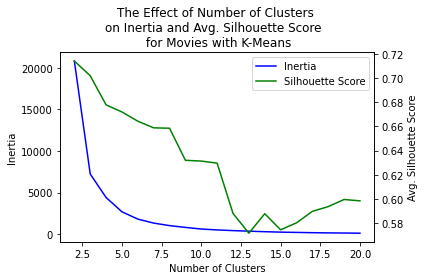

In [358]:
run_kmeans(X, np.arange(2, 21, 1), "Movies")

### K-Means results:
- Elbow method suggests K = 3 clusters
- Silhouette score is still higher for K = 11 clusters

#### K Means with K = 3

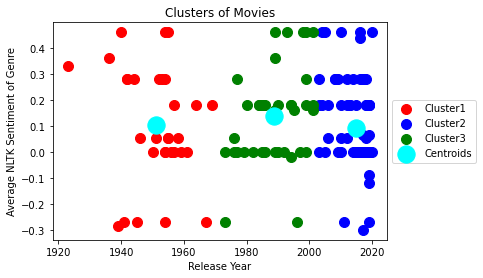

In [359]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)
#print(Y_kmeans)

#print(Y_kmeans.shape)
#print(X.shape)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 11

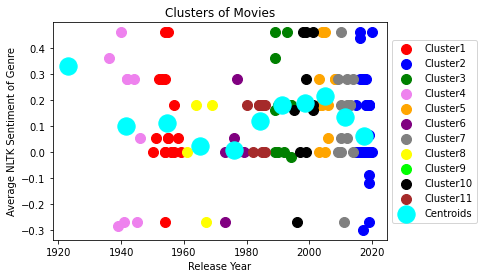

In [360]:
kmeans = KMeans(n_clusters = 11, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_kmeans == 9, 0], X[Y_kmeans == 9, 1], s = 100, color = 'black', label = 'Cluster10')
plt.scatter(X[Y_kmeans == 10, 0], X[Y_kmeans == 10, 1], s = 100, color = 'brown', label = 'Cluster11')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### The above results are not useful because we did not SCALE the data - only the movie Release Year is dividing up our dataset! 

<Figure size 432x288 with 0 Axes>

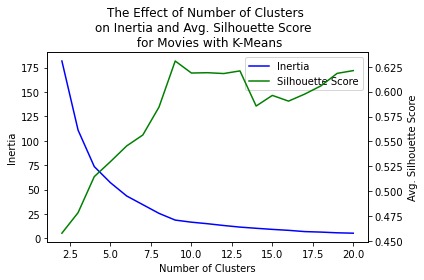

In [361]:
# Use Feature scaling 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_sc = sc_X.fit_transform(X)

run_kmeans(X_sc, np.arange(2, 21, 1), "Movies")

- K = 4 looks like a kink in the elbow, otherwise K = 9 

#### K-Means with K = 4, Scaled Data

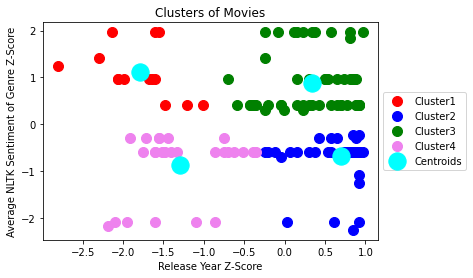

In [362]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X_sc)

plt.scatter(X_sc[Y_kmeans == 0, 0], X_sc[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X_sc[Y_kmeans == 1, 0], X_sc[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X_sc[Y_kmeans == 2, 0], X_sc[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X_sc[Y_kmeans == 3, 0], X_sc[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 9, Scaled Data

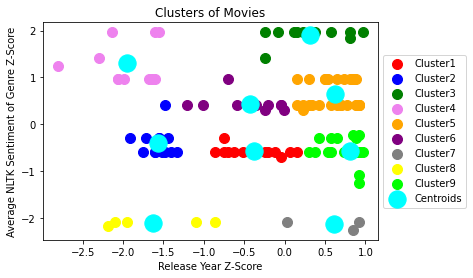

In [363]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X_sc)


plt.scatter(X_sc[Y_kmeans == 0, 0], X_sc[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X_sc[Y_kmeans == 1, 0], X_sc[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X_sc[Y_kmeans == 2, 0], X_sc[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X_sc[Y_kmeans == 3, 0], X_sc[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X_sc[Y_kmeans == 4, 0], X_sc[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X_sc[Y_kmeans == 5, 0], X_sc[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X_sc[Y_kmeans == 6, 0], X_sc[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X_sc[Y_kmeans == 7, 0], X_sc[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X_sc[Y_kmeans == 8, 0], X_sc[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [364]:
data['KMeans_Cluster'] = Y_kmeans

In [365]:
data.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster
0,13th,0.90,Documentary/History,2016,Ava DuVernay,Documentary,History,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0000,0.0000,0.00000,0.0,0.0,0.0,8
1,500 Days of Summer,0.85,Romance/Drama,2009,Marc Webb,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.27870,0.0,0.0,0.0,4
2,A Beautiful Day in the Neighborhood,0.85,Drama,2019,Marielle Heller,Drama,Drama,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.0,0.0,0.0,8
3,All the President's Men,0.90,Drama/Thriller,1976,Alan J. Pakula,Drama,Thriller,0,0,1,1,0,0,0,0,0,0,0,0,0,0.0000,0.1027,0.05135,0.0,0.0,0.0,0
4,Along Came Polly,0.65,Romance/Comedy,2004,Hamburg,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.0,0.0,0.0,2


### 2) Expectation Maximization

No Scaling Needed
https://stats.stackexchange.com/questions/371333/is-it-important-to-make-a-feature-scaling-before-using-gaussian-mixture-model

In [366]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()


Covariance type: full


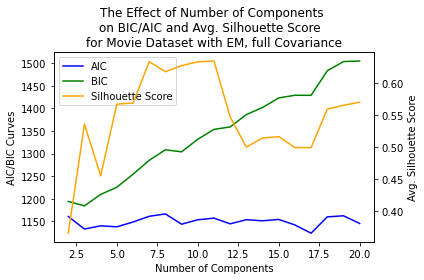

Covariance type: tied


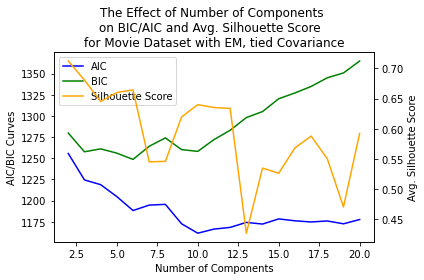

Covariance type: diag


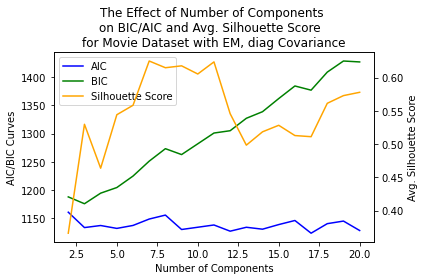

Covariance type: spherical


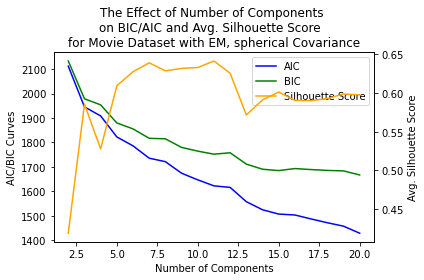

In [367]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X, np.arange(2, 21, 1), "Movie Dataset", cv)

- full: K = 7
- tied: K = 10
- diag: K = 6 
- spherical: K = 7 or 8 


#### Try Tied Covariance with K = 10, this has a high separation of clusters, as determined by the higher Silhouette Score. This shows us how far apart the clusters are. 

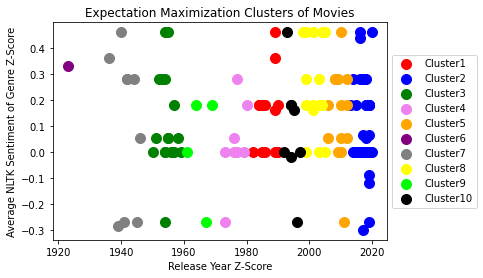

In [368]:
em = EM(n_components = 10, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_em == 9, 0], X[Y_em == 9, 1], s = 100, color = 'black', label = 'Cluster10')


plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The cluster 9 looks quite small. It may be better to have fewer clusters 

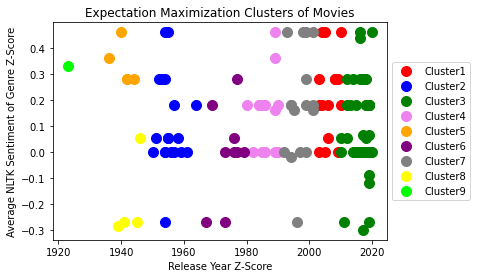

In [369]:
em = EM(n_components = 9, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [370]:
data['EM_Cluster'] = Y_em

### 3) Hierarchical Clustering 

#### Use Dendrogram to find optimal cluster size - Pick longest Vertical Line. Then, if a horizontal line was drawn through this line, how many cluster groups would we have? 

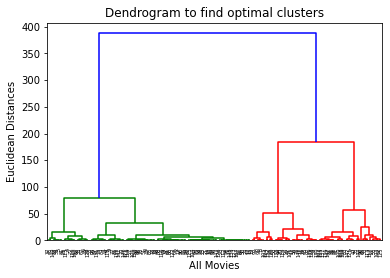

In [371]:
import scipy.cluster.hierarchy as sch

# Ward tries to minimize variance within cluster. Similar to WCSS for KMeans.
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward' ))

plt.title('Dendrogram to find optimal clusters')
plt.xlabel('All Movies')
plt.ylabel('Euclidean Distances')
plt.show()

- Pick line. Looks like 7 Clusters

#### Hierarchical Clustering with K = 7

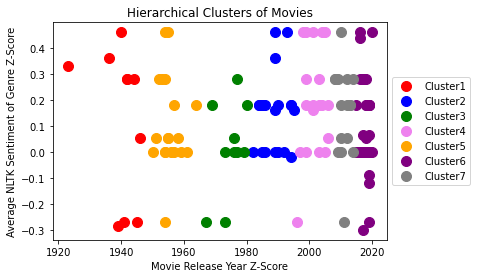

In [372]:
from sklearn.cluster import AgglomerativeClustering 

# Prepare hc algorithm 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
Y_hc = hc.fit_predict(X)

plt.scatter(X[Y_hc == 0, 0], X[Y_hc == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_hc == 1, 0], X[Y_hc == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_hc == 2, 0], X[Y_hc == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_hc == 3, 0], X[Y_hc == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_hc == 4, 0], X[Y_hc == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_hc == 5, 0], X[Y_hc == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_hc == 6, 0], X[Y_hc == 6, 1], s = 100, color = 'gray', label = 'Cluster7')


plt.title('Hierarchical Clusters of Movies')
plt.xlabel('Movie Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [373]:
data['Hierarchical_Cluster'] = Y_hc

In [374]:
data.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster
0,13th,0.90,Documentary/History,2016,Ava DuVernay,Documentary,History,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0000,0.0000,0.00000,0.0,0.0,0.0,8,2,5
1,500 Days of Summer,0.85,Romance/Drama,2009,Marc Webb,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.27870,0.0,0.0,0.0,4,0,6
2,A Beautiful Day in the Neighborhood,0.85,Drama,2019,Marielle Heller,Drama,Drama,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.0,0.0,0.0,8,2,5
3,All the President's Men,0.90,Drama/Thriller,1976,Alan J. Pakula,Drama,Thriller,0,0,1,1,0,0,0,0,0,0,0,0,0,0.0000,0.1027,0.05135,0.0,0.0,0.0,0,5,2
4,Along Came Polly,0.65,Romance/Comedy,2004,Hamburg,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.0,0.0,0.0,2,0,3


### Use Cluster Number, Movie Release Year, and Average NLTK Sentiment as Inputs into Decision Trees and other Regression Methods - See how this improves from earlier when we had no clusters 

Split Data

In [375]:
X_2 = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind','Genre_NLTK','KMeans_Cluster']]
y_2  = data.loc[:, 'Rating']

X_Train_2, X_Test_2, Y_Train_2, Y_Test_2 = train_test_split(X_2, y_2, test_size = .20, train_size = .80, random_state = 42)
    

#### 1) Decision Tree with Augmented Data

In [376]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_2, Y_Train_2)

Y_Test_Pred = dt_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: -0.5870080965470945
Mean Squared Error: 0.03372903225806452


Grid Search on New Datasets

In [377]:
make_GridSearchCV_DT(X_Train_2, Y_Train_2)

0.00892431433667431
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 8, 'splitter': 'random'}


R2 Score: 0.1845821958720909
Mean Squared Error: 0.01733025400378871


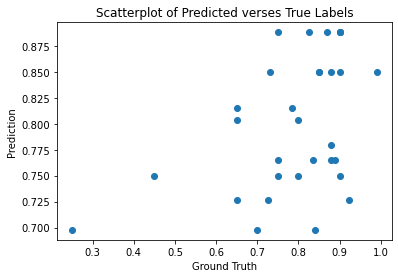

In [378]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 7, min_samples_leaf = 8,
                                 random_state = 42)

dt_model.fit(X_Train_2, Y_Train_2)

Y_Test_Pred = dt_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

This chart shows Decision Tree is only giving us 4 possible predicted values - which makes sense, given tree stops at depth of 3

#### 2) Boosted Decision Tree w/ Augmented Data

Default

In [379]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_2, Y_Train_2)
Y_Test_Pred = boosted_dt_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: 0.10296226373179085
Mean Squared Error: 0.0190649403800277


In [380]:
make_GridSearchCV_Boosted_DT(X_Train_2, Y_Train_2)

-0.06588254382712182
{'learning_rate': 0.8999999999999999, 'loss': 'linear', 'n_estimators': 10}


Best Params

R2 Score: 0.13053094414391753
Mean Squared Error: 0.01847901714941783


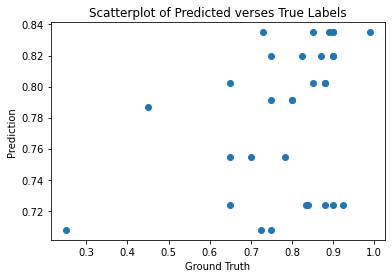

In [381]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train_2, Y_Train_2)
Y_Test_Pred = boosted_dt_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [382]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_2_sc, Y_Train_2)

Y_Test_Pred = ann_model.predict(X_Test_2_sc)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: -0.6641552801054773
Mean Squared Error: 0.03536865832457357


In [383]:
make_GridSearchCV_ANN(X_Train_2_sc, Y_Train_2)

-0.05130751880571782
{'activation': 'identity', 'hidden_layer_sizes': 80, 'learning_rate_init': 0.05, 'solver': 'adam'}


Best Params

R2 Score: 0.040332550194691064
Mean Squared Error: 0.02039602346196174


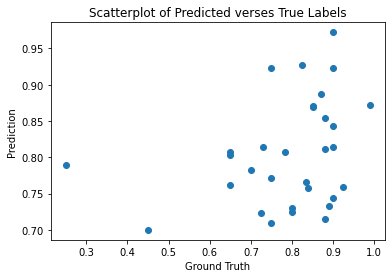

In [384]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

ann_model =  MLPRegressor(activation = 'identity', solver = 'adam', random_state = 42, \
                          hidden_layer_sizes = 15, learning_rate_init = 0.05)

ann_model.fit(X_Train_2_sc, Y_Train_2)

Y_Test_Pred = ann_model.predict(X_Test_2_sc)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) Random Forest

In [385]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_2, Y_Train_2)
Y_Test_Pred = rf_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: 0.0329567413420222
Mean Squared Error: 0.020552783150373073


In [386]:
make_GridSearchCV_RF(X_Train_2, Y_Train_2)

-0.016953623592077593
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 17, 'n_estimators': 100}


R2 Score: 0.0329567413420222
Mean Squared Error: 0.020552783150373073


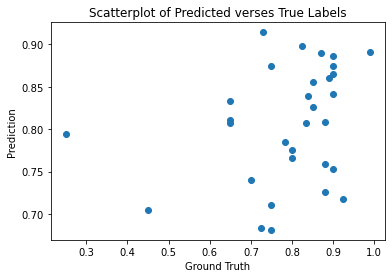

In [387]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_2, Y_Train_2)
Y_Test_Pred = rf_model.predict(X_Test_2)

print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 5) KNN

In [388]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_2_sc, Y_Train_2)
Y_Test_Pred = knn_model.predict(X_Test_2_sc)
            
print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: 0.17860458461607087
Mean Squared Error: 0.017457297491039428


In [389]:
make_GridSearchCV_KNN(X_Train_2_sc, Y_Train_2)

0.013519900994153834
{'n_neighbors': 23, 'p': 1, 'weights': 'uniform'}


R2 Score: 0.1372059877941213
Mean Squared Error: 0.01833715097804066


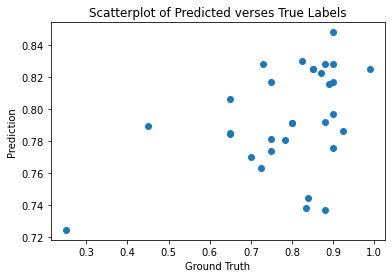

In [390]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

knn_model = KNeighborsRegressor(n_neighbors = 23, weights = 'uniform', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_2_sc, Y_Train_2)
Y_Test_Pred = knn_model.predict(X_Test_2_sc)
            
print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 6) SVM

In [573]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

svm_model = SVR(C = 1.0, kernel = 'rbf', degree = 3)
svm_model.fit(X_Train_2_sc, Y_Train_2)
Y_Test_Pred = svm_model.predict(X_Test_2_sc)
            
print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

R2 Score: 0.08142910482161625
Mean Squared Error: 0.01952258934418833


In [574]:
make_GridSearchCV_SVM(X_Train_2_sc, Y_Train_2)

-0.11174057186449877
{'C': 1, 'degree': 4, 'kernel': 'poly'}


R2 Score: 0.13509830022225155
Mean Squared Error: 0.018381946125750483


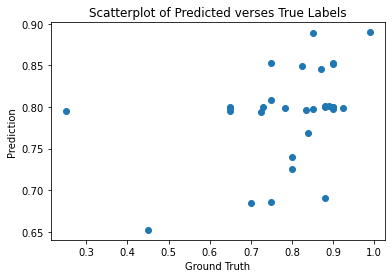

In [576]:
sc = StandardScaler()
X_Train_2_sc = sc.fit_transform(X_Train_2)
X_Test_2_sc = sc.transform(X_Test_2)

svm_model = SVR(C = 1.0, kernel = 'poly', degree = 4)
svm_model.fit(X_Train_2_sc, Y_Train_2)
Y_Test_Pred = svm_model.predict(X_Test_2_sc)
            
print("R2 Score:", r2_score(Y_Test_2, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_2, Y_Test_Pred))

plt.scatter(Y_Test_2, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### Maybe it is a dimensionality problem? 


In [391]:
X_3 = data.loc[:, ['ReleaseYear','Genre_NLTK','KMeans_Cluster']]
y_3  = data.loc[:, 'Rating']

X_Train_3, X_Test_3, Y_Train_3, Y_Test_3 = train_test_split(X_3, y_3, test_size = .20, train_size = .80, random_state = 42)
    

#### 1) Decision Tree with 3 Dimensions

Defaults

In [392]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_3, Y_Train_3)

Y_Test_Pred = dt_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: -0.7055491214671863
Mean Squared Error: 0.036248410742731975


In [393]:
make_GridSearchCV_DT(X_Train_3, Y_Train_3)

-0.03518452854107275
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 7, 'splitter': 'random'}


Best Params

R2 Score: 0.11951829068594277
Mean Squared Error: 0.018713071496424052


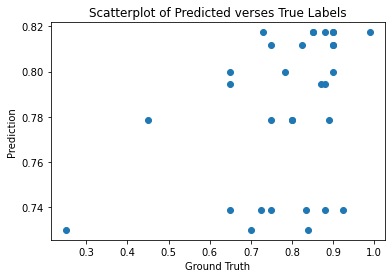

In [394]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 4, min_samples_leaf = 7,
                                 random_state = 42)

dt_model.fit(X_Train_3, Y_Train_3)

Y_Test_Pred = dt_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree with 3 Params

In [395]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train_3, Y_Train_3)
Y_Test_Pred = boosted_dt_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: 0.07431753987330691
Mean Squared Error: 0.019673732998759928


In [396]:
make_GridSearchCV_Boosted_DT(X_Train_3, Y_Train_3)

-0.13898208131064976
{'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 10}


R2 Score: 0.09720419193906982
Mean Squared Error: 0.01918731794676066


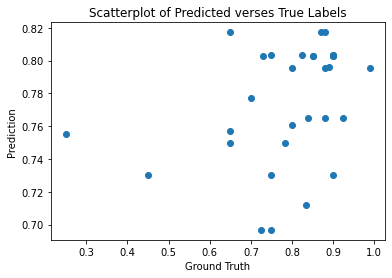

In [397]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_3, Y_Train_3)
Y_Test_Pred = boosted_dt_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [398]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)
ann_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = ann_model.predict(X_Test_3_sc)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: 0.08221688897020585
Mean Squared Error: 0.019505846394345803


In [399]:
make_GridSearchCV_ANN(X_Train_3_sc, Y_Train_3)

-0.07520442583461688
{'activation': 'logistic', 'hidden_layer_sizes': 70, 'learning_rate_init': 0.01, 'solver': 'adam'}


R2 Score: 0.031761594240580004
Mean Squared Error: 0.020578183874682784


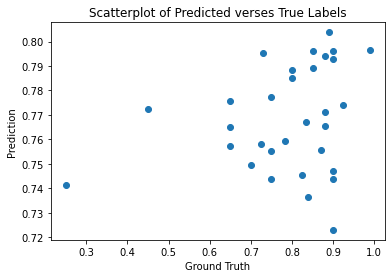

In [400]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         hidden_layer_sizes = (70,), learning_rate_init = 0.01)

ann_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = ann_model.predict(X_Test_3_sc)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) KNN

In [401]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = knn_model.predict(X_Test_3_sc)
            
print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: 0.0388640897491066
Mean Squared Error: 0.020427232974910395


In [402]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

make_GridSearchCV_KNN(X_Train_3_sc, Y_Train_3)

-0.01766425433038952
{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}


R2 Score: 0.13181224181817908
Mean Squared Error: 0.01845178544802867


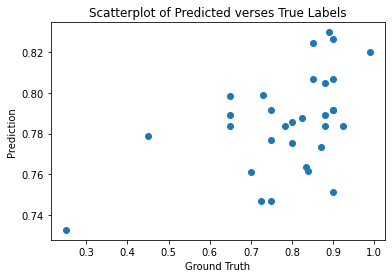

In [403]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

knn_model = KNeighborsRegressor(n_neighbors = 25, weights = 'uniform', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = knn_model.predict(X_Test_3_sc)
            
print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 5) Random Forest

In [404]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_3, Y_Train_3)
Y_Test_Pred = rf_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: -0.10650136262558818
Mean Squared Error: 0.02351671691832689


In [405]:
make_GridSearchCV_RF(X_Train_3, Y_Train_3)

-0.0389174995599181
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 19, 'n_estimators': 100}


R2 Score: 0.08485666031906858
Mean Squared Error: 0.01944974275305158


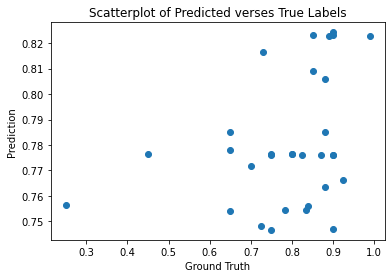

In [406]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = 3, min_samples_leaf = 19)
rf_model.fit(X_Train_3, Y_Train_3)
Y_Test_Pred = rf_model.predict(X_Test_3)

print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 6) SVM

In [578]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

svm_model = SVR(C = 1.0, kernel = 'rbf', degree = 3)
svm_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = svm_model.predict(X_Test_3_sc)
            
print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

R2 Score: 0.04352083175350596
Mean Squared Error: 0.020328262212489203


In [579]:
make_GridSearchCV_SVM(X_Train_3_sc, Y_Train_3)

-0.061394900774023056
{'C': 1, 'degree': 2, 'kernel': 'linear'}


R2 Score: 0.026530076123493562
Mean Squared Error: 0.02068937048029228


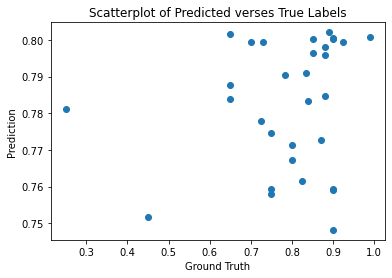

In [580]:
sc = StandardScaler()
X_Train_3_sc = sc.fit_transform(X_Train_3)
X_Test_3_sc = sc.transform(X_Test_3)

svm_model = SVR(C = 1.0, kernel = 'linear', degree = 2)
svm_model.fit(X_Train_3_sc, Y_Train_3)
Y_Test_Pred = svm_model.predict(X_Test_3_sc)
            
print("R2 Score:", r2_score(Y_Test_3, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_3, Y_Test_Pred))

plt.scatter(Y_Test_3, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### The Best result was using  Decision Trees on the full dataset including Movie Release Year, KMeans Cluster Groups, and Genre Binary Indicators 

##### A negative R2 value means that a horizontal line is still a better predictor

### Add IMBD Dataset for additional Dimensions 

In [407]:
meta = pd.read_csv('IMDB/movies_metadata.csv',
                  parse_dates = ['release_date'],
                  low_memory = False)

In [408]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [409]:
meta['release_datetime'] = pd.to_datetime(meta['release_date'],  errors='coerce', infer_datetime_format=True)
meta['release_year'] = meta['release_datetime'].dt.year
meta['release_year'] = meta['release_year'].fillna(0)

In [410]:
meta.shape

(45466, 26)

#### Merge Datasets on Title Column

In [411]:
data2 = pd.merge(data, meta, left_on = ['Name', 'ReleaseYear'], right_on = ['title', 'release_year'], how = 'left')

In [412]:
print(data.shape)
print(data2.shape)

(151, 29)
(153, 55)


#### Todo: de-dupe the new dataset, based on year or something else. 

In [413]:
data2 = data2.sort_values(by = 'vote_count', ascending = False)
#data3 = data2.drop_duplicates(subset = ['Name','ReleaseYear', 'WatchDate'], keep = 'first') # this keeps the movie with more ratings, probably the movie I watched
data3 = data2
print(data3.shape)

(153, 55)


In [414]:

#data3 = data3.sort_values(by = 'WatchDate', ascending = True)
data3

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
57,Inception,0.900000,Thriller/ScienceFiction,2010,Nolan,Thriller,ScienceFiction,0,0,0,1,0,0,0,0,0,0,0,1,0,0.1027,0.0000,0.05135,0.0,0.0,0.00,8,2,6,False,NaN,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",29.108149,/qmDpIHrmpJINaRKAfWQfftjCdyi.jpg,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-07-14,8.255328e+08,148.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0,2010-07-14,2010.0
38,Fight Club,0.900000,Action/Drama,1999,Fincher,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0000,0.00000,0.1,0.0,0.05,0,6,3,False,NaN,63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,550,tt0137523,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,63.869599,/adw6Lq9FiC9zjYEpOqfq03ituwp.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1999-10-15,1.008538e+08,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mischief. Mayhem. Soap.,Fight Club,False,8.3,9678.0,1999-10-15,1999.0
39,Forrest Gump,0.945000,Comedy/Drama,1994,Robert Zemeckis,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.0,0.0,0.00,5,6,1,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-07-06,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,1994-07-06,1994.0
137,The Wolf of Wall Street,0.800000,Comedy/Drama,2013,Scorsese,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.0,0.0,0.00,4,2,6,False,NaN,100000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.thewolfofwallstreet.com/,106646,tt0993846,en,The Wolf of Wall Street,A New York stockbroker refuses to cooperate in...,16.382422,/vK1o5rZGqxyovfIhZyMELhk03wO.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-12-25,3.920007e+08,180.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,EARN. SPEND. PARTY.,The Wolf of Wall Street,False,7.9,6768.0,2013-12-25,2013.0
10,Back to the Future,0.920000,Sci-Fi/Comedy,1985,Robert Zemeckis,Sci-Fi,Comedy,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.3612,0.18060,0.0,0.0,0.00,5,3,1,False,"{'id': 264, 'name': 'Back to the Future Collec...",19000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",http://www.backtothefuture.com/movies/backtoth...,105,tt0088763,en,Back to the Future,Eighties teenager Marty McFly is accidentally ...,25.778509,/pTpxQB1N0waaSc3OSn0e9oc8kx9.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1985-07-03,3.811098e+08,116.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,He's the only kid ever to get into trouble bef...,Back to the Future,False,8.0,6239.0,1985-07-03,1985.0
15,Beauty and the Beast,0.850000,Family/Musical,2017,Bill Condon,Family,Musical,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0000,0.0000,0.00000,0.

In [415]:
# Used to find proper name to join together 
meta[meta['title'].str.contains('40 Year', na = False)]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
10301,False,NaN,26000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.universalstudiosentertainment.com/t...,6957,tt0405422,en,The 40 Year Old Virgin,Andy Stitzer has a pleasant life with a nice a...,11.519662,/kFXfr0ioXRfxz4AvQ6RJ7iFF6PI.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-11,109449237.0,116.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"The longer you wait, the harder it gets",The 40 Year Old Virgin,False,6.2,2020.0,2005-08-11,2005.0


### New Data - Downloaded from IMDB, Updated Daily. This data source is more reliable than the one above; move ahead with this source

https://www.imdb.com/interfaces/


In [416]:
os.listdir('imdb_updated')

['title.principals.tsv.gz',
 'title.ratings.tsv',
 'title.akas.tsv.gz',
 '.DS_Store',
 'title.akas.tsv',
 'title.basics.tsv.gz',
 'title.crew.tsv.gz',
 'name.basics.tsv',
 'title.ratings.tsv.gz',
 'title.basics.tsv',
 'name.basics.tsv.gz',
 'title.episode.tsv',
 'title.crew.tsv',
 'title.episode.tsv.gz']

#### IMBD Data 1 

In [417]:
basics =  pd.read_csv('imdb_updated/title.basics.tsv', sep='\t', error_bad_lines=False)


/Users/amandahutter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [418]:
basics.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7445319,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7445320,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7445321,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7445322,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
7445323,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


In [419]:
basics.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult            int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

In [420]:
basics.shape

(7445324, 9)

In [421]:
basics.isna().sum()

tconst            0
titleType         0
primaryTitle      8
originalTitle     8
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            9
dtype: int64

In [422]:
#### Clean up IMDB Basics Data 

In [423]:
basics = basics[basics['startYear'] != '\\N']
basics = basics[basics['titleType'] == 'movie']
basics['startYear'] = basics['startYear'].astype(int)

In [424]:
print(min(basics['startYear']))
print(max(basics['startYear']))

1894
2028


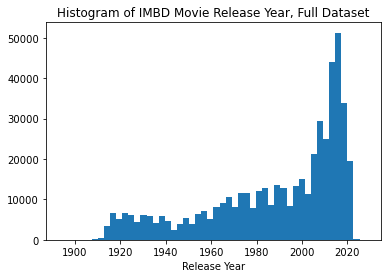

In [425]:
plt.hist(basics['startYear'], bins = 50)
plt.title('Histogram of IMBD Movie Release Year, Full Dataset')
plt.xlabel('Release Year')
plt.show()

#### IMDB Data 2

In [426]:
ratings = pd.read_csv('imdb_updated/title.ratings.tsv', sep = '\t', error_bad_lines = False)

In [427]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1666
1,tt0000002,6.1,207
2,tt0000003,6.5,1385
3,tt0000004,6.2,123
4,tt0000005,6.2,2174


In [428]:
basics_ratings = pd.merge(basics, ratings, left_on = 'tconst', right_on = 'tconst', how = 'left')

In [429]:
print(basics.shape)
print(ratings.shape)
print(basics_ratings.shape)

(493215, 9)
(1104266, 3)
(493215, 11)


#### IMDB Data #3

In [595]:
akas = pd.read_csv('imdb_updated/title.akas.tsv', sep = '\t', error_bad_lines = False, low_memory = False)


/Users/amandahutter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Try this merge 

In [430]:
data5 = pd.merge(data, basics_ratings, left_on = ['Name', 'ReleaseYear'], right_on = ['primaryTitle', 'startYear'], how = 'left')


In [431]:
print(data.shape)
print(data5.shape)
print('Need to de-duplicate the IMDB dataset results')

(151, 29)
(154, 40)
Need to de-duplicate the IMDB dataset results


In [432]:
print('Number missing data:', data5['averageRating'].isna().sum())

Number missing data: 2


Use this code to find the proper title for a movie

In [433]:
# Use this code to find the proper title for a movie
basics[basics['primaryTitle'].str.contains('Wizard of L', na = False)]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
94355,tt0096455,movie,The Wizard of Loneliness,The Wizard of Loneliness,0,1988,\N,111,Drama


'The Wizard of Lies' is a movie length TV show. We can just drop it from the data set

In [434]:
# If it can't be found, just drop those columns 

Clean up Duplicates

In [435]:
data5 = data5.sort_values(by = 'numVotes', ascending = False)
#data6 = data5.drop_duplicates(subset = ['Name','ReleaseYear', 'WatchDate'], keep = 'first') # this keeps the movie with more ratings, probably the movie I watched
data6 = data5
#data6 = data6.sort_values(by = 'WatchDate', ascending = True)
data7 = data6.drop(columns = ['isAdult', 'originalTitle','titleType','endYear'])


In [436]:
print(data7.shape)

(154, 36)


IMDB Ratings Data

In [437]:
data7

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
58,Inception,0.900000,Thriller/ScienceFiction,2010,Nolan,Thriller,ScienceFiction,0,0,0,1,0,0,0,0,0,0,0,1,0,0.1027,0.0000,0.05135,0.0,0.0,0.00,8,2,6,tt1375666,Inception,2010.0,148,"Action,Adventure,Sci-Fi",8.8,2045436.0
39,Fight Club,0.900000,Action/Drama,1999,Fincher,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0000,0.00000,0.1,0.0,0.05,0,6,3,tt0137523,Fight Club,1999.0,139,Drama,8.8,1837769.0
40,Forrest Gump,0.945000,Comedy/Drama,1994,Robert Zemeckis,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.0,0.0,0.00,5,6,1,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0
108,Star Wars: Episode IV - A New Hope,0.800000,ScienceFiction,1977,George Lucas,ScienceFiction,ScienceFiction,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.0,0.0,0.00,0,5,2,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,121,"Action,Adventure,Fantasy",8.6,1220910.0
138,The Wolf of Wall Street,0.800000,Comedy/Drama,2013,Scorsese,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.0,0.0,0.00,4,2,6,tt0993846,The Wolf of Wall Street,2013.0,180,"Biography,Crime,Drama",8.2,1168372.0
5,American Beauty,0.800000,Comedy/Drama,1999,Mendes,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.0,0.0,0.00,4,6,3,tt0169547,American Beauty,1999.0,122,Drama,8.3,1062513.0
10,Back to the Future,0.920000,Sci-Fi/Comedy,1985,Robert Zemeckis,Sci-Fi,Comedy,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.3612,0.18060,0.0,0.0,0.00,5,3,1,tt0088763,Back to the Future,1985.0,116,"Adventure,Comedy,Sci-Fi",8.5,1047525.0
143,V for Vendetta,0.900000,Mystery/Drama,2005,McTiegue,Mystery,Drama,0,0,1,0,0,0,0,0,1,0,0,0,0,0.0000,0.0000,0.00000,0.0,0.0,0.00,8,0,3,tt0434409,V for Vendetta,2005.0,132,"Action,Drama,Sci-Fi",8.2,1025404.0
142,Toy Story,0.750000,Adventure/Fantasy,1995,Lasseter,Adventure,Fantasy,0,0,0,0,1,0,0,0,0,0,0,0,0,0.3182,0.0000,0.15910,0.0,0.0,0.00,5,6,1,tt0114709,Toy Story,1995.0,81,"Adventure,Animation,Comedy",8.3,879216.0
109,Star Wars: Episode VII - The Force Awakens,0.850000,Fantasy/ScienceFiction,2015,Abrams,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.0,0.0,0.00,8,2,5,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.9,854500.0


In [438]:
full = data7.dropna()
full.loc[:,'runtimeMinutes'] = full.loc[:,'runtimeMinutes'].astype(int)

### Explore the Relationship between this New Data and our existing Features 

Potential Columsn to add to model:
  - averageRating (how good is the movie among other people)
  - numVotes (how popular is movie among other people)
  - runtimeMinutes (how long is the movie)

In [439]:
full.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
58,Inception,0.900,Thriller/ScienceFiction,2010,Nolan,Thriller,ScienceFiction,0,0,0,1,0,0,0,0,0,0,0,1,0,0.1027,0.0,0.05135,0.0,0.0,0.00,8,2,6,tt1375666,Inception,2010.0,148,"Action,Adventure,Sci-Fi",8.8,2045436.0
39,Fight Club,0.900,Action/Drama,1999,Fincher,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0,0.00000,0.1,0.0,0.05,0,6,3,tt0137523,Fight Club,1999.0,139,Drama,8.8,1837769.0
40,Forrest Gump,0.945,Comedy/Drama,1994,Robert Zemeckis,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0,0.18060,0.0,0.0,0.00,5,6,1,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0
108,Star Wars: Episode IV - A New Hope,0.800,ScienceFiction,1977,George Lucas,ScienceFiction,ScienceFiction,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.0,0.00000,0.0,0.0,0.00,0,5,2,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,121,"Action,Adventure,Fantasy",8.6,1220910.0
138,The Wolf of Wall Street,0.800,Comedy/Drama,2013,Scorsese,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0,0.18060,0.0,0.0,0.00,4,2,6,tt0993846,The Wolf of Wall Street,2013.0,180,"Biography,Crime,Drama",8.2,1168372.0


#### 1) IMDB Average Rating Verses my Rating

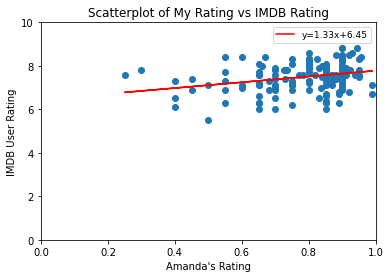

In [440]:
x = full['Rating']
y =  full['averageRating']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y)
plt.legend(fontsize=9)


plt.xlim(0,1)
plt.ylim(0,10)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB User Rating')
plt.title('Scatterplot of My Rating vs IMDB Rating')
plt.show()

- There is some positive relationship between the IMDB user rating and my rating for the movie

#### 2) IMDB Viewership vs My Rating

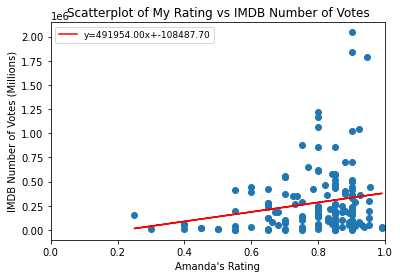

In [441]:
x = full['Rating']
y = full['numVotes']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y)
plt.legend(fontsize=9)


plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB Number of Votes (Millions)')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

#### 3) Runtime vs My Rating

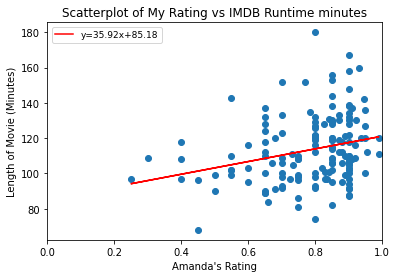

In [581]:
x = full['Rating']
y = full['runtimeMinutes']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y)
plt.legend(fontsize=9)

plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('Length of Movie (Minutes)')
plt.title('Scatterplot of My Rating vs IMDB Runtime minutes')
plt.show()

### Recall prior variables

#### 4) Release Year vs My Rating

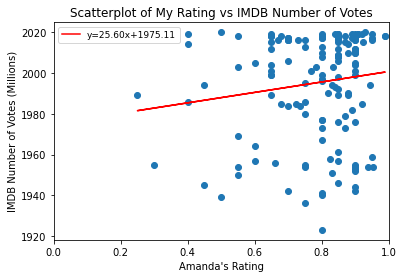

In [443]:
# plt.scatter(full['Rating'], full['startYear'])
x = full['Rating']
y = full['startYear']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y)
plt.legend(fontsize=9)


plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB Number of Votes (Millions)')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

#### 5) NLTK Score vs My Rating

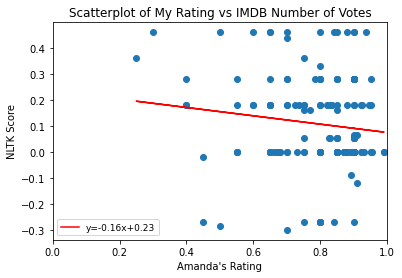

In [444]:
#plt.scatter(full['Rating'], full['Genre_NLTK'])
x = full['Rating']
y = full['Genre_NLTK']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y)
plt.legend(fontsize=9)

plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('NLTK Score')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

### We want to revisit the NLP scores using the new IMDB database genre columns - in order to get predictions from movies outside our original data -  but first, we can examine how good these 4 variables are

Split Data 

In [445]:
X_4 = full.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating']]
y_4 = full.loc[:, 'Rating']

X_Train_4, X_Test_4, Y_Train_4, Y_Test_4 = train_test_split(X_4, y_4, test_size = .20, train_size = .80, random_state = 42)
    

### Data: IMDB 4 Features 
### Try: Decision Tree, Boosted Decision Tree, ANN

#### 1) Decision Tree

Default

In [446]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_4, Y_Train_4)

Y_Test_Pred = dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.6745696358492179
Mean Squared Error: 0.039372222222222225


In [447]:
make_GridSearchCV_DT(X_Train_4, Y_Train_4)

0.016336040912114845
{'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 10, 'splitter': 'random'}


Best Params

R2 Score: 0.17184215673018877
Mean Squared Error: 0.01947151909497017


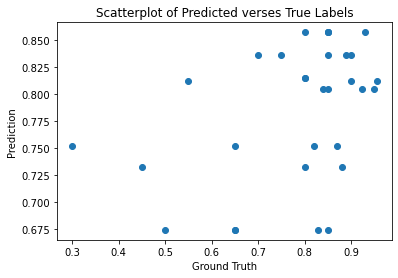

In [448]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 5, min_samples_leaf = 10,
                                 random_state = 42)

dt_model.fit(X_Train_4, Y_Train_4)

Y_Test_Pred = dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

Default

In [449]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = boosted_dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.24369054422718062
Mean Squared Error: 0.029241459676985417


In [450]:
make_GridSearchCV_Boosted_DT(X_Train_4, Y_Train_4)

-0.047232457304088246
{'learning_rate': 0.6, 'loss': 'linear', 'n_estimators': 15}


Best Params

R2 Score: -0.0870097600846671
Mean Squared Error: 0.02555760531873851


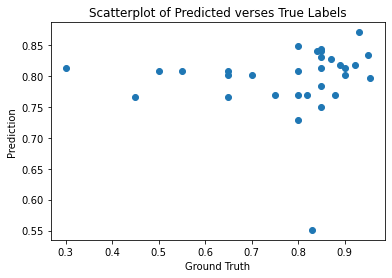

In [451]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 15, learning_rate = 0.6, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = boosted_dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [452]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_4_sc, Y_Train_4)

Y_Test_Pred = ann_model.predict(X_Test_4_sc)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -1.389597568530319
Mean Squared Error: 0.05618384836062389


In [453]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

make_GridSearchCV_ANN(X_Train_4_sc, Y_Train_4)

0.07143880943055891
{'activation': 'logistic', 'hidden_layer_sizes': 45, 'learning_rate_init': 0.01, 'solver': 'adam'}


R2 Score: 0.15115504333343777
Mean Squared Error: 0.01995791130485886


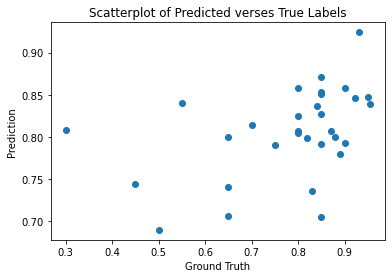

In [454]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         learning_rate_init = 0.01, hidden_layer_sizes = (45,), max_iter=2000)

ann_model.fit(X_Train_4_sc, Y_Train_4)

Y_Test_Pred = ann_model.predict(X_Test_4_sc)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) KNN

In [455]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_4_sc, Y_Train_4)
Y_Test_Pred = knn_model.predict(X_Test_4_sc)
            
print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: 0.019593965349578912
Mean Squared Error: 0.023051155017921144


In [456]:
make_GridSearchCV_KNN(X_Train_4_sc, Y_Train_4)

0.08589854197539193
{'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}


R2 Score: 0.09240857459137042
Mean Squared Error: 0.02133914918984567


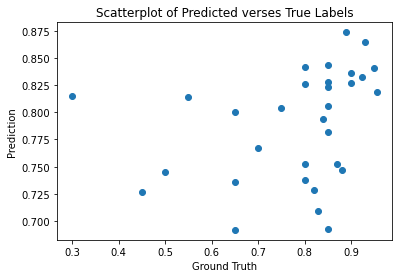

In [457]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

knn_model = KNeighborsRegressor(n_neighbors = 11, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_4_sc, Y_Train_4)
Y_Test_Pred = knn_model.predict(X_Test_4_sc)
            
print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

R2 Score: 0.06589498525589743
Mean Squared Error: 0.021962532600649957


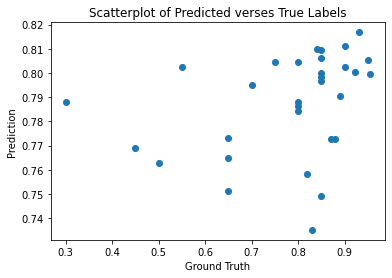

In [458]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

knn_model = KNeighborsRegressor(n_neighbors = 49, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_4_sc, Y_Train_4)
Y_Test_Pred = knn_model.predict(X_Test_4_sc)
            
print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 5) Random Forest

In [459]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = rf_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.10182063437297395
Mean Squared Error: 0.025905836303763443


In [460]:
make_GridSearchCV_RF(X_Train_4, Y_Train_4)

-0.04133365305995747
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 18, 'n_estimators': 50}


R2 Score: 0.1197719479127326
Mean Squared Error: 0.020695785789426702


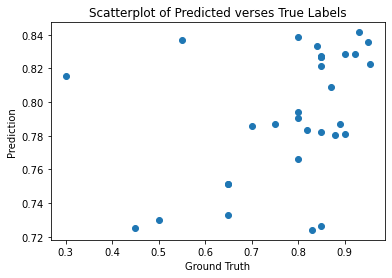

In [461]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 50,
                                max_depth = 3, min_samples_leaf = 18)
rf_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = rf_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### Add Back the NLP NLTK Scores for the Genre Column, using Genre from IMDB Data, not original dataset 

#### Split out Genre Column

In [462]:
full[['Genre_1','Genre_2','Genre_3']] = full['genres'].str.split(',',expand=True)

In [463]:
full.head()

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3
58,Inception,0.900,Thriller/ScienceFiction,2010,Nolan,Thriller,ScienceFiction,0,0,0,1,0,0,0,0,0,0,0,1,0,0.1027,0.0,0.05135,0.0,0.0,0.00,8,2,6,tt1375666,Inception,2010.0,148,"Action,Adventure,Sci-Fi",8.8,2045436.0,Action,Adventure,Sci-Fi
39,Fight Club,0.900,Action/Drama,1999,Fincher,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0,0.00000,0.1,0.0,0.05,0,6,3,tt0137523,Fight Club,1999.0,139,Drama,8.8,1837769.0,Drama,None,None
40,Forrest Gump,0.945,Comedy/Drama,1994,Robert Zemeckis,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0,0.18060,0.0,0.0,0.00,5,6,1,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0,Drama,Romance,None
108,Star Wars: Episode IV - A New Hope,0.800,ScienceFiction,1977,George Lucas,ScienceFiction,ScienceFiction,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.0,0.00000,0.0,0.0,0.00,0,5,2,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,121,"Action,Adventure,Fantasy",8.6,1220910.0,Action,Adventure,Fantasy
138,The Wolf of Wall Street,0.800,Comedy/Drama,2013,Scorsese,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0,0.18060,0.0,0.0,0.00,4,2,6,tt0993846,The Wolf of Wall Street,2013.0,180,"Biography,Crime,Drama",8.2,1168372.0,Biography,Crime,Drama


### Use new IMDB Genre columns + NLTK to get scores to use 

In [464]:
genre1 = list(full['Genre_1'].unique())
genre2 = list(full['Genre_2'].unique())
genre3 = list(full['Genre_3'].unique())

genre_list = list(set().union(genre1, genre2, genre3))

genre_list.remove('Music')
genre_list.remove(None)
genre_list.append('Other')

In [465]:
#genre_list

In [466]:

full['Mystery'] = 0 
r = re.compile(r'.*(Mystery).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Mystery'] = 1
  
full['Film-Noir'] = 0 
r = re.compile(r'.*(Film-Noir).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Film-Noir'] = 1
 
full['Horror'] = 0 
r = re.compile(r'.*(Horror).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Horror'] = 1

full['Thriller'] = 0 
r = re.compile(r'.*(Thriller).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Thriller'] = 1
 
full['Animation'] = 0 
r = re.compile(r'.*(Animation).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Animation'] = 1

full['Sci-Fi'] = 0 
r = re.compile(r'.*(Sci-Fi).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Sci-Fi'] = 1

full['Sport'] = 0 
r = re.compile(r'.*(Sport).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Sport'] = 1

full['Romance'] = 0 
r = re.compile(r'.*(Romance).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Romance'] = 1

full['Documentary'] = 0 
r = re.compile(r'.*(Documentary).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Documentary'] = 1

full['Adventure'] = 0 
r = re.compile(r'.*(Adventure).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Adventure'] = 1

# music and musical 
full['Musical'] = 0 
r = re.compile(r'.*(Music).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Musical'] = 1

full['Comedy'] = 0 
r = re.compile(r'.*(Comedy).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Comedy'] = 1

full['Crime'] = 0 
r = re.compile(r'.*(Crime).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Crime'] = 1

full['Fantasy'] = 0 
r = re.compile(r'.*(Fantasy).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Fantasy'] = 1

full['Action'] = 0 
r = re.compile(r'.*(Action).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Action'] = 1

full['History'] = 0 
r = re.compile(r'.*(History).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'History'] = 1

full['Family'] = 0 
r = re.compile(r'.*(Family).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Family'] = 1

full['Biography'] = 0 
r = re.compile(r'.*(Biography).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Biography'] = 1

full['Drama'] = 0 
r = re.compile(r'.*(Drama).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Drama'] = 1

full['War'] = 0 
r = re.compile(r'.*(War).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'War'] = 1

full['Other'] = 0
full.loc[ (full['Mystery'] == 0) & (full['Film-Noir'] == 0) & (full['Horror'] == 0) & \
          (full['Thriller'] == 0) & (full['Animation'] == 0) & (full['Sci-Fi'] == 0) & \
         (full['Sport'] == 0) & (full['Romance'] == 0) & (full['Documentary'] == 0) & \
         (full['Adventure'] == 0) & (full['Musical'] == 0 ) & (full['Comedy'] == 0) & \
         (full['Crime'] == 0) & (full['Fantasy'] == 0) & (full['Action'] == 0) & \
         (full['History'] == 0) & (full['Family'] == 0) & (full['Biography'] == 0) & \
         (full['Drama'] == 0) & (full['War'] == 0)
         , 'Other'] = 1



### Count of each movie type 

In [467]:
full.iloc[:,-21:].sum()

Mystery        10
Film-Noir       7
Horror          1
Thriller       13
Animation       5
Sci-Fi         10
Sport           7
Romance        35
Documentary     3
Adventure      17
Musical        15
Comedy         74
Crime          24
Fantasy        10
Action         17
History         8
Family          7
Biography      24
Drama          94
War             2
Other           0
dtype: int64

In [468]:
full[full.Horror == 1]

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
106,Son of Frankenstein,0.5,Horror/Drama,1939,Lee,Horror,Drama,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.5719,0.0,-0.28595,0.0,0.0,0.0,7,7,0,tt0031951,Son of Frankenstein,1939.0,99,"Drama,Horror,Sci-Fi",7.1,9043.0,Drama,Horror,Sci-Fi,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [469]:
full[full.War == 1]

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
23,Casablanca,0.90,Romance/Drama,1942,Michael Curtiz,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.2787,0.0,0.0,0.0,3,4,0,tt0034583,Casablanca,1942.0,102,"Drama,Romance,War",8.5,517765.0,Drama,Romance,War,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
60,Jojo Rabbit,0.91,War/Comedy,2019,Waitiki,War,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.5994,0.3612,-0.1191,0.0,0.0,0.0,8,2,5,tt2584384,Jojo Rabbit,2019.0,108,"Comedy,Drama,War",7.9,284488.0,Comedy,Drama,War,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [470]:
full[full.Documentary == 1]

,Name,Rating,Genre,ReleaseYear,Director,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
0,13th,0.90,Documentary/History,2016,Ava DuVernay,Documentary,History,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,8,2,5,tt5895028,13th,2016.0,100,"Crime,Documentary,History",8.3,31166.0,Crime,Documentary,History,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
63,Knock Down the House,0.90,Documentary/Political,2019,Rachel Lears,Documentary,Political,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,8,2,5,tt9358052,Knock Down the House,2019.0,87,Documentary,7.1,11283.0,Documentary,None,None,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
77,"Monrovia, Indiana",0.55,Documentary,2018,Frederick Wiseman,Documentary,Documentary,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,8,2,5,tt8749146,"Monrovia, Indiana",2018.0,143,Documentary,6.9,508.0,Documentary,None,None,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Consolidate the columns

In [471]:
full.loc[(full['Horror'] == 1) |(full['War'] == 1) | (full['Documentary'] == 1) |
         (full['Animation'] == 1) | (full['Film-Noir'] == 1) | (full['Sport'] == 1) |
         (full['History'] == 1) & (full['Family'] == 1) , "Other"] = 1

full = full.drop(columns = ['Horror','Documentary','War', 'Animation', 'Film-Noir', 'Sport', 'History', 'Family'])

genre_list.remove('Horror')
genre_list.remove('War')
genre_list.remove('Documentary')

genre_list.remove('Animation')
genre_list.remove('Film-Noir')
genre_list.remove('Sport')
genre_list.remove('History')
genre_list.remove('Family')

In [472]:
full[full.Comedy == 1]['Rating'].mean()

0.7560698198198197

In [473]:
for i in range(0, len(genre_list)):
    genre = genre_list[i]
    print(genre + " : " + str(full[full[genre] == 1]['Rating'].mean()))
    

Adventure : 0.7944117647058823
Sci-Fi : 0.795
Action : 0.7626470588235296
Drama : 0.7986879432624113
Crime : 0.7999999999999999
Romance : 0.7688809523809523
Comedy : 0.7560698198198197
Biography : 0.8509722222222219
Fantasy : 0.7695000000000001
Mystery : 0.873
Musical : 0.8244999999999999
Thriller : 0.8507692307692308
Other : 0.76


In [474]:
full.iloc[:,-13:].sum()

Mystery      10
Thriller     13
Sci-Fi       10
Romance      35
Adventure    17
Musical      15
Comedy       74
Crime        24
Fantasy      10
Action       17
Biography    24
Drama        94
Other        25
dtype: int64

In [475]:
# Replace Blanks with filling forward Genre 1 and Genre 2 
full['Genre_2'] = full['Genre_2'].fillna(full['Genre_1'])
full['Genre_3'] = full['Genre_3'].fillna(full['Genre_1'])

### Use NLTK Vader Score, from Prior Analysis, to get sentiment of each column

In [476]:
# Apply this function to my Genre Columns
full['Genre_1_NLTK'] = full['Genre_1'].apply(get_vader_score)
full['Genre_2_NLTK'] = full['Genre_2'].apply(get_vader_score)
full['Genre_3_NLTK'] = full['Genre_3'].apply(get_vader_score)
full['Genres_NLTK'] = (full['Genre_1_NLTK'] + full['Genre_2_NLTK'] + full['Genre_3_NLTK'] ) / 3

#### Histograms of Genre NLTK Scores using IMDB genres column

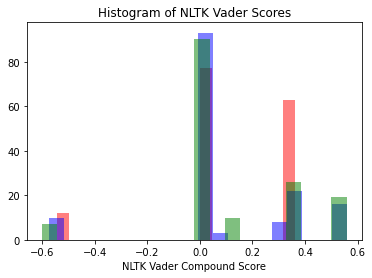

In [477]:
plt.hist(full['Genre_1_NLTK'], bins = 20, color = 'red', alpha = .5)
plt.hist(full['Genre_2_NLTK'], bins = 20, color = 'blue', alpha = .5)
plt.hist(full['Genre_3_NLTK'], bins = 20, color = 'green', alpha = .5)

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

#### Histogram of Average Genre NLTK Score using IMDB Genres Column

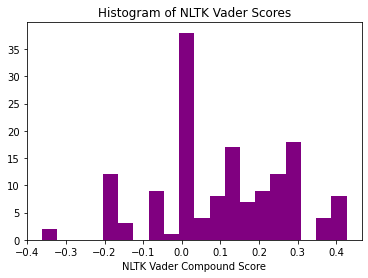

In [478]:
plt.hist(full['Genres_NLTK'], bins = 20, color = 'purple')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

#### Histogram Comparing NLTK Score using the 3 Genre columns from IMDB, verses the Manual 2 Genres from my original Dataset

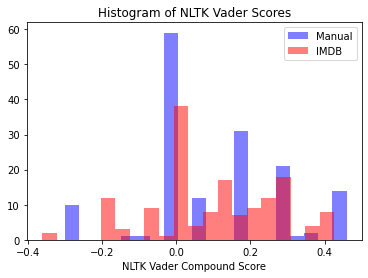

In [479]:
plt.hist(full['Genre_NLTK'], bins = 20, color = 'blue', alpha = .5, label = 'Manual')
plt.hist(full['Genres_NLTK'], bins = 20, color = 'red', alpha = .5, label = 'IMDB')

plt.legend()
plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

- The IMDB Genre column gives data that is more spaced out than my manual data column, with much lower peaks

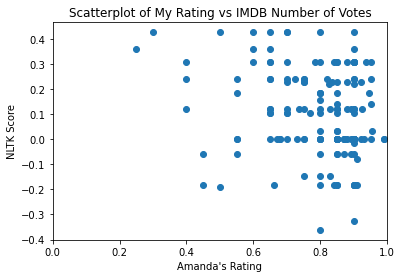

In [480]:
plt.scatter(full['Rating'], full['Genres_NLTK'])
plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('NLTK Score')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

### Data: IMDB 4 Features + NLTK Score on IMDB Genres Column


In [481]:
X_5 = full.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK']]
y_5 = full.loc[:, 'Rating']

X_Train_5, X_Test_5, Y_Train_5, Y_Test_5 = train_test_split(X_5, y_5, test_size = .20, train_size = .80, random_state = 42)



#### 1) Decision Tree with IMDB Data

Default

In [482]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_5, Y_Train_5)

Y_Test_Pred = dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.23652835364152014
Mean Squared Error: 0.017950627240143367


In [483]:
make_GridSearchCV_DT(X_Train_5, Y_Train_5)

0.001421297836236146
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 4, 'splitter': 'random'}


R2 Score: 0.15851854913957852
Mean Squared Error: 0.019784781695478967


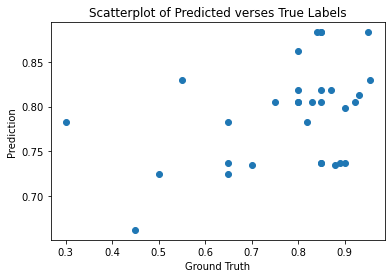

In [484]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 5, min_samples_leaf = 4,
                                 random_state = 42)

dt_model.fit(X_Train_5, Y_Train_5)

Y_Test_Pred = dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

Default

In [485]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = boosted_dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.09784974262133317
Mean Squared Error: 0.021211217288873686


In [486]:
make_GridSearchCV_Boosted_DT(X_Train_5, Y_Train_5)

-0.025216084488744083
{'learning_rate': 0.6, 'loss': 'linear', 'n_estimators': 10}


Best Params

R2 Score: 0.18329997245160612
Mean Squared Error: 0.0192021247042519


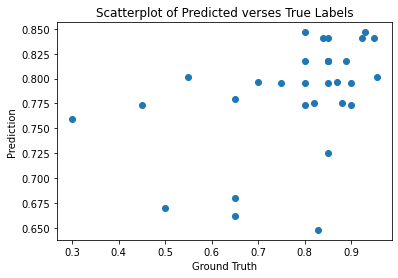

In [487]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.6, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = boosted_dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [488]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_5_sc, Y_Train_5)

Y_Test_Pred = ann_model.predict(X_Test_5_sc)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -1.9089768009585546
Mean Squared Error: 0.06839541252552732


In [489]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

make_GridSearchCV_ANN(X_Train_5_sc, Y_Train_5)

0.033799683975018445
{'activation': 'identity', 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01, 'solver': 'adam'}


Best Params

R2 Score: 0.2106986937522114
Mean Squared Error: 0.018557930207613305


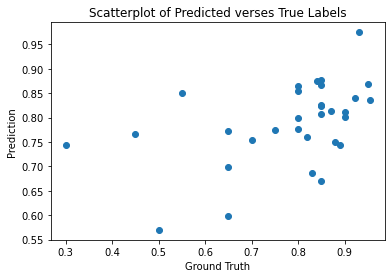

In [490]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

ann_model =  MLPRegressor(activation = 'identity', solver = 'adam', random_state = 42,
                         hidden_layer_sizes = (20,), learning_rate_init = 0.01)

ann_model.fit(X_Train_5_sc, Y_Train_5)

Y_Test_Pred = ann_model.predict(X_Test_5_sc)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) Random Forest

In [491]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = rf_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.3092048412386379
Mean Squared Error: 0.016241868906810043


In [492]:
make_GridSearchCV_RF(X_Train_5, Y_Train_5)

-0.04368064682593502
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 15, 'n_estimators': 100}


R2 Score: 0.3092048412386379
Mean Squared Error: 0.016241868906810043


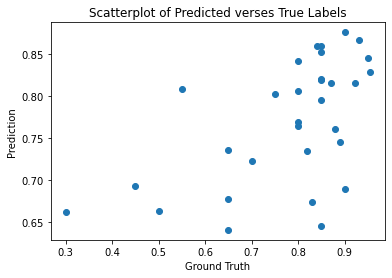

In [493]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)

rf_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = rf_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### The most important columns

In [494]:

# How many features do we need to get 95% of feature importance? 
def run_RFR(X_Data, Y_Data, n_est, min_samples, max_depth):
    
    rfr = RandomForestRegressor(n_estimators=n_est, min_samples_leaf=min_samples, max_depth = max_depth, criterion = 'mse',
                                random_state=42)
    
    importances = rfr.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    #return (importances, top_cols)
    return importances

In [495]:
run_RFR(X_Train_5, Y_Train_5, 100, 12, 5)

,Feature Importance,Cum Sum
averageRating,0.333770,0.333770
runtimeMinutes,0.306389,0.640159
numVotes,0.167455,0.807614
Genres_NLTK,0.102698,0.910313


#### 5) KNN

In [496]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)
Y_Test_Pred = knn_model.predict(X_Test_5_sc)
            
print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.12634820838247762
Mean Squared Error: 0.020541165770609323


In [497]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

make_GridSearchCV_KNN(X_Train_5_sc, Y_Train_5)

0.04508328945638982
{'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


In [498]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

knn_model = KNeighborsRegressor(n_neighbors = 11, weights = 'distance', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)
Y_Test_Pred = knn_model.predict(X_Test_5_sc)
            
print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.14296185448937204
Mean Squared Error: 0.0201505482934745


In [634]:

def nearest_neighbors(X_Train, X_Test, Y_Train, Y_Test, p, weights, datasetname):
    
    nearest_neighbors = list(np.arange(1, 70, 2))
    r2_scores_test = []
    r2_scores_train = []
    mse_test = []
    mse_train = []
    
    for k in nearest_neighbors:
        model = KNeighborsRegressor(n_neighbors = k,p = p, weights = weights)
        model.fit(X_Train, Y_Train)

        Y_Pred = model.predict(X_Test)
        r2 = r2_score(Y_Test, Y_Pred)
        r2_scores_test.append(r2)
        mse = mean_squared_error(Y_Test, Y_Pred)
        mse_test.append(mse)
        
        Y_Pred = model.predict(X_Train)
        r2 = r2_score(Y_Train, Y_Pred)
        r2_scores_train.append(r2)
        mse = mean_squared_error(Y_Train, Y_Pred)
        mse_train.append(mse)

    plt.plot(nearest_neighbors, r2_scores_test,label = "Test")
    plt.plot(nearest_neighbors, r2_scores_train, label = "Train")
    plt.xlabel("Nearest Neighbors")
    plt.ylabel("R2 Score")
    plt.title(datasetname + "\n"+ str(p) + " degree \n" + weights +" weights")
    plt.legend()
    plt.show()
    
    plt.plot(nearest_neighbors, mse_test,label = "Test")
    plt.plot(nearest_neighbors, mse_train, label = "Train")
    plt.xlabel("Nearest Neighbors")
    plt.ylabel("MSE")
    plt.title(datasetname + "\n"+ str(p) + " degree \n" + weights +" weights")
    plt.legend()
    plt.show()

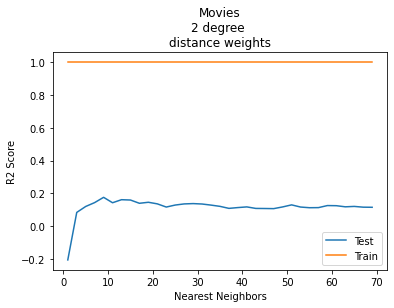

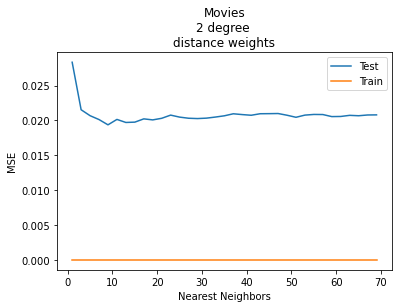

In [637]:
nearest_neighbors(X_Train_5_sc, X_Test_5_sc, Y_Train_5, Y_Test_5, 2, 'distance', "Movies")

### Data: IMDB 4 Features + NLTK Average Score + 21 binary indicators

In [500]:
#full.columns

In [501]:
X_6 = full.loc[:, [
                    'startYear','numVotes','averageRating','Genres_NLTK',
                    #'startYear','numVotes','averageRating',
                   #'startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK',
                  'Mystery', 'Thriller', 'Sci-Fi', 'Romance',
           'Adventure', 'Musical', 'Comedy', 'Crime', 'Fantasy', 'Action',
           'Biography', 'Drama', 'Other']]

y_6 = full.loc[:, 'Rating']

X_Train_6, X_Test_6, Y_Train_6, Y_Test_6 = train_test_split(X_6, y_6, test_size = .20, train_size = .80, random_state = 42)
 

#### 1) Decision Tree

In [502]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))



R2 Score: -0.8750595943673578
Mean Squared Error: 0.044086111111111104


In [503]:
make_GridSearchCV_DT(X_Train_6, Y_Train_6)

-0.03842981692165839
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 11, 'splitter': 'random'}


R2 Score: -0.061148185220891715
Mean Squared Error: 0.02494955197132616


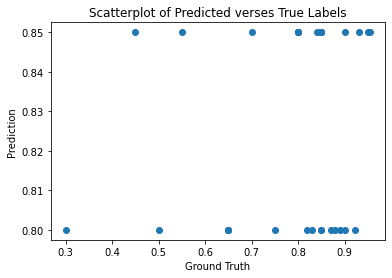

In [504]:
dt_model = DecisionTreeRegressor(criterion = 'mae', splitter = 'random', 
                                 max_depth = 1, min_samples_leaf = 11,
                                 random_state = 42)

dt_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted DT

In [505]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = boosted_dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: 0.05482186234300157
Mean Squared Error: 0.022222882153566235


In [506]:
make_GridSearchCV_Boosted_DT(X_Train_6, Y_Train_6)

0.0020732799774590303
{'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 15}


R2 Score: 0.12687804072507003
Mean Squared Error: 0.020528708434535338


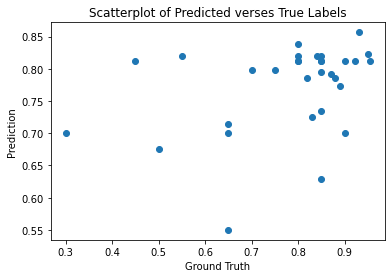

In [507]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 15, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = boosted_dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [508]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_6_sc, Y_Train_6)

Y_Test_Pred = ann_model.predict(X_Test_6_sc)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -0.5178975650843662
Mean Squared Error: 0.03568857273156295


In [509]:
make_GridSearchCV_ANN(X_Train_6, Y_Train_6)

-0.08467934620724578
{'activation': 'logistic', 'hidden_layer_sizes': 20, 'learning_rate_init': 0.05, 'solver': 'adam'}


R2 Score: 0.15294188484289684
Mean Squared Error: 0.019915899363712773


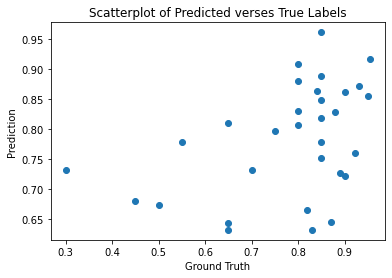

In [510]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         learning_rate_init = 0.05, hidden_layer_sizes = (20, ))

ann_model.fit(X_Train_6_sc, Y_Train_6)

Y_Test_Pred = ann_model.predict(X_Test_6_sc)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) Random Forest 

R2 Score: 0.18293094432146617
Mean Squared Error: 0.019210801236559116


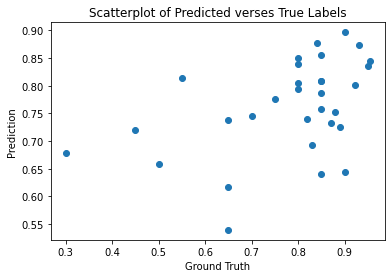

In [638]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = rf_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

In [512]:
make_GridSearchCV_RF(X_Train_6, Y_Train_6)

-0.04044821699440595
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 19, 'n_estimators': 100}


R2 Score: 0.0887382404083702
Mean Squared Error: 0.021425445519355796


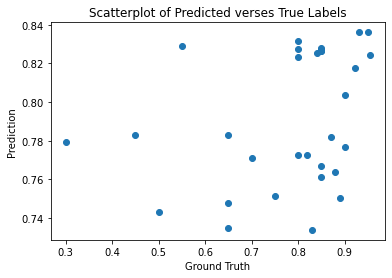

In [513]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = 3, min_samples_leaf = 19)

rf_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = rf_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

In [514]:
run_RFR(X_Train_6, Y_Train_6, 50, 12, 5)

,Feature Importance,Cum Sum
averageRating,0.402693,0.402693
startYear,0.205741,0.608434
numVotes,0.164798,0.773232
Genres_NLTK,0.122007,0.895239


- 4 Features provide 95% of the feature importance. 
- We get 94% of the feature importance without using the Binary Columns

#### 5) KNN 

Default

In [524]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = knn_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: 0.03010087091989111
Mean Squared Error: 0.02280411827956989


In [525]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

make_GridSearchCV_KNN(X_Train_6_sc, Y_Train_6)

0.00043820559158294083
{'n_neighbors': 31, 'p': 2, 'weights': 'distance'}


R2 Score: 0.12808069532206268
Mean Squared Error: 0.02050043180570147


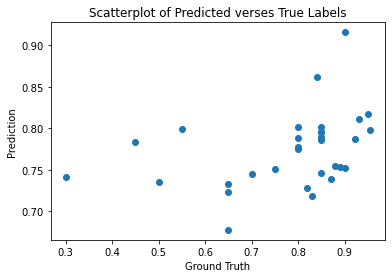

In [526]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

knn_model = KNeighborsRegressor(n_neighbors = 31, weights = 'distance', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = knn_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 6) SVM 

In [520]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

svm_model = SVR(C = 1.0, kernel = 'rbf', degree = 3)
svm_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_red = svm_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -0.17917348252856824
Mean Squared Error: 0.027724544503114852


In [522]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

make_GridSearchCV_SVM(X_Train_6_sc, Y_Train_6)

-0.15663986736420413
{'C': 1, 'degree': 2, 'kernel': 'linear'}


Best Params

R2 Score: 0.4922607999768216
Mean Squared Error: 0.011937885523708338


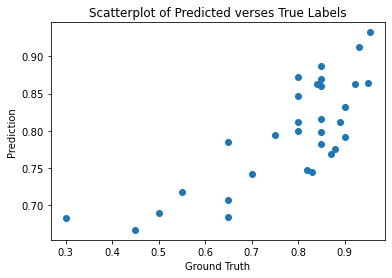

In [523]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

svm_model = SVR(C = 1.0, kernel = 'linear', degree = 2)
svm_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = svm_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 7) XGBoost Tree

In [515]:
data_dmatrix = xgboost.DMatrix(data=X_6,label=y_6)

xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = xgb_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))


R2 Score: -0.930430401985151
Mean Squared Error: 0.04538798097395864


In [516]:
def make_GridSearchCV_XGB(X_Train, Y_Train):
    
    learning_rates = np.arange(.1, 1, 0.1)
    max_depths = np.arange(3, 10, 2)
    num_estimators = np.arange(10, 100, 10)
    objectives = ['reg:squarederror', 'reg:logistic']
    
    param_grid = {'learning_rate': learning_rates, 'n_estimators': num_estimators,
                 'max_depth': max_depths, 'objective': objectives}

    classifier = GridSearchCV(xgboost.XGBRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)

In [517]:
#make_GridSearchCV_XGB(X_Train_6, Y_Train_6)

In [518]:
data_dmatrix = xgboost.DMatrix(data=X_6,label=y_6)

xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.4,
                max_depth = 3, alpha = 10, n_estimators = 10)

xgb_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = xgb_model.predict(X_Test_6)


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.4,
                'max_depth': 3, 'alpha': 10}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#cv_results

R2 Score: -0.17917348252856824
Mean Squared Error: 0.027724544503114852


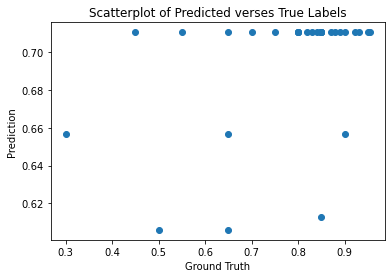

In [519]:
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### Data: Remove the Release Year, not found to be useful

In [527]:
X_7 = full.loc[:, ['startYear','numVotes','averageRating','Genres_NLTK']]
y_7 = full.loc[:, 'Rating']

X_Train_7, X_Test_7, Y_Train_7, Y_Test_7 = train_test_split(X_7, y_7, test_size = .20, train_size = .80, random_state = 42)
    

#### 1) Decision Tree

In [528]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_7, Y_Train_7)

Y_Test_Pred = dt_model.predict(X_Test_7)

print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))



R2 Score: -0.3974958440689247
Mean Squared Error: 0.032857706093189956


In [529]:
make_GridSearchCV_DT(X_Train_7, Y_Train_7)

0.011796456581754166
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 3, 'splitter': 'random'}


R2 Score: 0.08898376042886069
Mean Squared Error: 0.021419672890615964


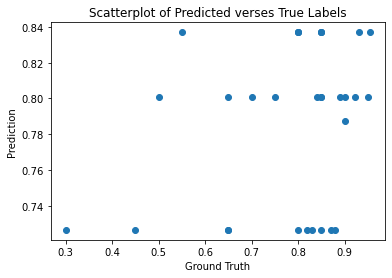

In [530]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 3,
                                 random_state = 42)

dt_model.fit(X_Train_7, Y_Train_7)

Y_Test_Pred = dt_model.predict(X_Test_7)

print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

plt.scatter(Y_Test_7, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 7) KNN

In [531]:
sc = StandardScaler()
X_Train_7_sc = sc.fit_transform(X_Train_7)
X_Test_7_sc = sc.transform(X_Test_7)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_7_sc, Y_Train_7)
Y_Test_Pred = knn_model.predict(X_Test_7_sc)
            
print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

R2 Score: 0.048912215622071376
Mean Squared Error: 0.022361828853046602


In [532]:
make_GridSearchCV_KNN(X_Train_7_sc, Y_Train_7)

0.02592402075304361
{'n_neighbors': 43, 'p': 1, 'weights': 'uniform'}


R2 Score: 0.0831196403761888
Mean Squared Error: 0.021557549174115218


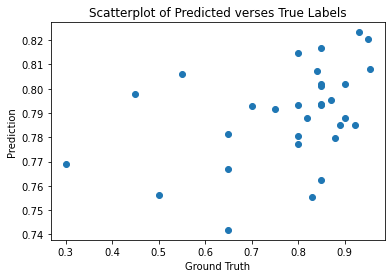

In [533]:
sc = StandardScaler()
X_Train_7_sc = sc.fit_transform(X_Train_7)
X_Test_7_sc = sc.transform(X_Test_7)

knn_model = KNeighborsRegressor(n_neighbors = 43, weights = 'uniform', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_7_sc, Y_Train_7)
Y_Test_Pred = knn_model.predict(X_Test_7_sc)
            
print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

plt.scatter(Y_Test_7, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### Final Step: Get Some Movie Recommendations 

Based on the model developed above, use the model to rank the IMDB Dataset and get some movie recommendations

In [534]:
basics_ratings.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,6.0,154.0
1,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",6.0,39.0
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.5,8.0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",6.1,607.0
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.5,14.0


In [535]:
basics_ratings.shape

(493215, 11)

#### Keep same pre-processing we used to build the model

In [536]:
basics_ratings[['Genre_1','Genre_2','Genre_3']] = basics_ratings['genres'].str.split(',',expand=True)

# Replace Blanks with filling forward Genre 1 and Genre 2 
basics_ratings['Genre_2'] = basics_ratings['Genre_2'].fillna(basics_ratings['Genre_1'])
basics_ratings['Genre_3'] = basics_ratings['Genre_3'].fillna(basics_ratings['Genre_1'])

In [537]:
# Apply this function to my Genre Columns
basics_ratings['Genre_1_NLTK'] = basics_ratings['Genre_1'].apply(get_vader_score)
basics_ratings['Genre_2_NLTK'] = basics_ratings['Genre_2'].apply(get_vader_score)
basics_ratings['Genre_3_NLTK'] = basics_ratings['Genre_3'].apply(get_vader_score)
basics_ratings['Genres_NLTK'] = (basics_ratings['Genre_1_NLTK'] + basics_ratings['Genre_2_NLTK'] + basics_ratings['Genre_3_NLTK'] ) / 3

In [538]:

basics_ratings['Mystery'] = 0 
r = re.compile(r'.*(Mystery).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Mystery'] = 1
  
basics_ratings['Film-Noir'] = 0 
r = re.compile(r'.*(Film-Noir).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Film-Noir'] = 1
 
basics_ratings['Horror'] = 0 
r = re.compile(r'.*(Horror).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Horror'] = 1

basics_ratings['Thriller'] = 0 
r = re.compile(r'.*(Thriller).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Thriller'] = 1
 
basics_ratings['Animation'] = 0 
r = re.compile(r'.*(Animation).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Animation'] = 1

basics_ratings['Sci-Fi'] = 0 
r = re.compile(r'.*(Sci-Fi).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Sci-Fi'] = 1

basics_ratings['Sport'] = 0 
r = re.compile(r'.*(Sport).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Sport'] = 1

basics_ratings['Romance'] = 0 
r = re.compile(r'.*(Romance).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Romance'] = 1

basics_ratings['Documentary'] = 0 
r = re.compile(r'.*(Documentary).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Documentary'] = 1

basics_ratings['Adventure'] = 0 
r = re.compile(r'.*(Adventure).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Adventure'] = 1

# music and musical 
basics_ratings['Musical'] = 0 
r = re.compile(r'.*(Music).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Musical'] = 1

basics_ratings['Comedy'] = 0 
r = re.compile(r'.*(Comedy).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Comedy'] = 1

basics_ratings['Crime'] = 0 
r = re.compile(r'.*(Crime).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Crime'] = 1

basics_ratings['Fantasy'] = 0 
r = re.compile(r'.*(Fantasy).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Fantasy'] = 1

basics_ratings['Action'] = 0 
r = re.compile(r'.*(Action).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Action'] = 1

basics_ratings['History'] = 0 
r = re.compile(r'.*(History).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'History'] = 1

basics_ratings['Family'] = 0 
r = re.compile(r'.*(Family).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Family'] = 1

basics_ratings['Biography'] = 0 
r = re.compile(r'.*(Biography).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Biography'] = 1

basics_ratings['Drama'] = 0 
r = re.compile(r'.*(Drama).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Drama'] = 1

basics_ratings['War'] = 0 
r = re.compile(r'.*(War).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'War'] = 1

basics_ratings['Other'] = 0
basics_ratings.loc[ (basics_ratings['Mystery'] == 0) & (basics_ratings['Film-Noir'] == 0) & \
                   (basics_ratings['Horror'] == 0) & (basics_ratings['Documentary'] == 0) & (basics_ratings['War'] == 0) & \
          (basics_ratings['Thriller'] == 0) & (basics_ratings['Animation'] == 0) & (basics_ratings['Sci-Fi'] == 0) & \
         (basics_ratings['Sport'] == 0) & \
        (basics_ratings['Romance'] == 0) &  \
         (basics_ratings['Adventure'] == 0) & (basics_ratings['Musical'] == 0 ) & (basics_ratings['Comedy'] == 0) & \
         (basics_ratings['Crime'] == 0) & (basics_ratings['Fantasy'] == 0) & (basics_ratings['Action'] == 0) & \
         (basics_ratings['History'] == 0) & (basics_ratings['Family'] == 0) & (basics_ratings['Biography'] == 0) & \
         (basics_ratings['Drama'] == 0) , 'Other'] = 1



In [539]:
basics_ratings.iloc[:,-21:].sum()

Mystery         12559
Film-Noir         784
Horror          23087
Thriller        27458
Animation        6165
Sci-Fi           7908
Sport            5307
Romance         39139
Documentary     95902
Adventure       21811
Musical         18411
Comedy          86483
Crime           29025
Fantasy         10533
Action          39925
History         11128
Family          14033
Biography       12679
Drama          179085
War              7817
Other           77287
dtype: int64

In [540]:
basics_ratings.loc[(basics_ratings['Horror'] == 1) |(basics_ratings['War'] == 1) | (basics_ratings['Documentary'] == 1) |
         (basics_ratings['Animation'] == 1) | (basics_ratings['Film-Noir'] == 1) | (basics_ratings['Sport'] == 1) |
         (basics_ratings['History'] == 1) & (basics_ratings['Family'] == 1) , "Other"] = 1

basics_ratings = basics_ratings.drop(columns = ['Horror','Documentary','War', 'Animation', 'Film-Noir', 'Sport', 'History', 'Family'])



#### Break it down

In [541]:
basics_ratings = basics_ratings.dropna()
basics_ratings = basics_ratings[basics_ratings['runtimeMinutes'] != "\\N"]

X_Valid_6 = basics_ratings.loc[:, [
       # 'startYear', 'runtimeMinutes', 'numVotes', 'averageRating', 'Genres_NLTK',
       'startYear', 'numVotes', 'averageRating', 'Genres_NLTK',
        #'startYear', 'numVotes', 'averageRating',
        'Mystery', 'Thriller', 'Sci-Fi', 'Romance', 'Adventure',
       'Musical', 'Comedy', 'Biography', 'Drama',
       'Other', 'Crime', 'Fantasy', 'Action']]

X_Valid_5 = basics_ratings.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK']]


#### 6 vars

In [655]:
# This model gives a lot of Mystery Thrillers 
sc = StandardScaler()

X_TrainTest_6 = pd.concat([X_Train_6, X_Test_6])
Y_TrainTest_6 = pd.concat([Y_Train_6, Y_Test_6])

X_TrainTest_6_sc = sc.fit_transform(X_TrainTest_6)
X_Valid_6_sc = sc.transform(X_Valid_6)

knn_model = KNeighborsRegressor(n_neighbors = 30, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_TrainTest_6_sc, Y_TrainTest_6)

Y_Valid_Pred = knn_model.predict(X_Valid_6_sc)

#### This one is best, using just 5 variables

In [715]:
sc = StandardScaler()
X_TrainTest_5 = pd.concat([X_Train_5, X_Test_5])
Y_TrainTest_5 = pd.concat([Y_Train_5, Y_Test_5])

X_TrainTest_5_sc = sc.fit_transform(X_TrainTest_5)
X_Valid_5_sc = sc.transform(X_Valid_5)

#knn_model = KNeighborsRegressor(n_neighbors = 59, weights = 'distance', p = 2, algorithm = 'auto')
knn_model = KNeighborsRegressor(n_neighbors = 31, weights = 'distance', p = 2, algorithm = 'auto')


knn_model.fit(X_TrainTest_5_sc, Y_TrainTest_5)

# New Validation Set
Y_Valid_Pred = knn_model.predict(X_Valid_5_sc)

In [716]:
basics_ratings['pred_rating'] = Y_Valid_Pred

#### The Highest Rated Movies, according to my model

In [717]:
basics_ratings.sort_values(by = 'pred_rating', ascending = False).head(12)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Genre_1_NLTK,Genre_2_NLTK,Genre_3_NLTK,Genres_NLTK,Mystery,Thriller,Sci-Fi,Romance,Adventure,Musical,Comedy,Crime,Fantasy,Action,Biography,Drama,Other,pred_rating
404113,tt4669788,movie,On the Basis of Sex,On the Basis of Sex,0,2018,\N,120,"Biography,Drama",7.1,26268.0,Biography,Drama,Biography,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.990000
420341,tt5437928,movie,Colette,Colette,0,2018,\N,111,"Biography,Drama,History",6.7,19129.0,Biography,Drama,History,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.990000
33916,tt0047396,movie,Rear Window,Rear Window,0,1954,\N,112,"Mystery,Thriller",8.4,440373.0,Mystery,Thriller,Mystery,0.0000,0.1027,0.0000,0.034233,1,1,0,0,0,0,0,0,0,0,0,0,0,0.955000
420833,tt5462602,movie,The Big Sick,The Big Sick,0,2017,\N,120,"Comedy,Drama,Romance",7.5,119925.0,Comedy,Drama,Romance,0.3612,0.0000,0.5574,0.306200,0,0,0,1,0,0,1,0,0,0,0,1,0,0.950000
475895,tt8637428,movie,The Farewell,The Farewell,0,2019,\N,100,"Comedy,Drama",7.6,48734.0,Comedy,Drama,Comedy,0.3612,0.0000,0.3612,0.240800,0,0,0,0,0,0,1,0,0,0,0,1,0,0.950000
407686,tt4846340,movie,Hidden Figures,Hidden Figures,0,2016,\N,127,"Biography,Drama,History",7.8,197949.0,Biography,Drama,History,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.950000
38505,tt0053125,movie,North by Northwest,North by Northwest,0,1959,\N,136,"Adventure,Mystery,Thriller",8.3,296705.0,Adventure,Mystery,Thriller,0.3182,0.0000,0.1027,0.140300,1,1,0,0,1,0,0,0,0,0,0,0,0,0.950000
76838,tt0109830,movie,Forrest Gump,Forrest Gump,0,1994,\N,142,"Drama,Romance",8.8,1789260.0,Drama,Romance,Drama,0.0000,0.5574,0.0000,0.185800,0,0,0,1,0,0,0,0,0,0,0,1,0,0.945000
34155,tt0047673,movie,White Christmas,White Christmas,0,1954,\N,120,"Comedy,Musical,Romance",7.6,32649.0,Comedy,Musical,Romance,0.3612,0.0000,0.5574,0.306200,0,0,0,1,0,1,1,0,0,0,0,0,0,0.937500
474401,tt8503618,movie,Hamilton,Hamilton,0,2020,\N,160,"Biography,Drama,History",8.6,49768.0,Biography,Drama,History,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.930000


### Top 100 Movies that I should see, based on my algorithm

In [718]:
#akas = pd.read_csv('imdb_updated/title.akas.tsv', sep = '\t', error_bad_lines = False, low_memory = False)

In [719]:
# Remove Previously Watched
watched_list = full['Name'].unique()
to_watch = basics_ratings[~basics_ratings['primaryTitle'].isin(watched_list)]

# Remove non English Films
english_list = akas[akas['region'] == 'US']['titleId']
to_watch = to_watch[to_watch['tconst'].isin(english_list)]

# Restrict to Films with at least some votes
to_watch = to_watch[to_watch['numVotes'] > 10000]
to_watch.sort_values(by = 'pred_rating', ascending = False).head(100)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Genre_1_NLTK,Genre_2_NLTK,Genre_3_NLTK,Genres_NLTK,Mystery,Thriller,Sci-Fi,Romance,Adventure,Musical,Comedy,Crime,Fantasy,Action,Biography,Drama,Other,pred_rating
318718,tt1821593,movie,Rundskop,Rundskop,0,2011,\N,129,"Crime,Drama",7.4,22140.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.860787
423318,tt5580266,movie,The Hate U Give,The Hate U Give,0,2018,\N,133,"Crime,Drama",7.4,30017.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.860589
50100,tt0068646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1602199.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.857968
80938,tt0117381,movie,Primal Fear,Primal Fear,0,1996,\N,129,"Crime,Drama,Mystery",7.7,187355.0,Crime,Drama,Mystery,-0.5423,0.0000,0.0000,-0.180767,1,0,0,0,0,0,0,1,0,0,0,1,0,0.857820
194786,tt0400234,movie,Black Friday,Black Friday,0,2004,\N,143,"Action,Crime,Drama",8.5,18682.0,Action,Crime,Drama,0.0000,-0.5423,0.0000,-0.180767,0,0,0,0,0,0,0,1,0,1,0,1,0,0.857790
64396,tt0089881,movie,Ran,Ran,0,1985,\N,162,"Action,Drama,War",8.2,111412.0,Action,Drama,War,0.0000,0.0000,-0.5994,-0.199800,0,0,0,0,0,0,0,0,0,1,0,1,1,0.857384
104720,tt0168629,movie,Dancer in the Dark,Dancer in the Dark,0,2000,\N,140,"Crime,Drama,Musical",8.0,101523.0,Crime,Drama,Musical,-0.5423,0.0000,0.0000,-0.180767,0,0,0,0,0,1,0,1,0,0,0,1,0,0.856904
89420,tt0133093,movie,The Matrix,The Matrix,0,1999,\N,136,"Action,Sci-Fi",8.7,1660273.0,Action,Sci-Fi,Action,0.0000,0.0000,0.0000,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0.856392
56959,tt0078788,movie,Apocalypse Now,Apocalypse Now,0,1979,\N,147,"Drama,Mystery,War",8.4,601446.0,Drama,Mystery,War,0.0000,0.0000,-0.5994,-0.199800,1,0,0,0,0,0,0,0,0,0,0,1,1,0.856054
232637,tt10324144,movie,Article 15,Article 15,0,2019,\N,130,"Crime,Drama,Mystery",8.2,22802.0,Crime,Drama,Mystery,-0.5423,0.0000,0.0000,-0.180767,1,0,0,0,0,0,0,1,0,0,0,1,0,0.855819
